In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [39]:
def trans_probab(current_state, next_state, action):
    act_value = [-1, -10, 1, 10]
    column = int(current_state/10)
    row = int(current_state%10)
    not_allowed = []
    if row==0:
        not_allowed.append(0) # top
    elif row==9:
        not_allowed.append(2) # bottom
    if column==0:
        not_allowed.append(1) # left
    elif column==9:
        not_allowed.append(3) # right
    
    value_action = act_value[action]
    neighbours = []
    for idx in np.arange(0,4):
        if idx not in not_allowed:
            neighbours.append(current_state + act_value[idx])
    if not_allowed: # not empty => edges or corners
        if len(not_allowed)==2: 
            if action in not_allowed:
                if next_state==current_state: # => same_state
                    return 1-w+w/4+w/4
                elif next_state in neighbours: # neighboring valid states
                    return w/4
            else: # action to stay in the grid
                if next_state==current_state: # => same_state
                    return w/4+w/4
                elif next_state==current_state+value_action and next_state in neighbours: # intended state
                    return 1-w+w/4
                elif next_state in neighbours: 
                    return w/4      
        else: # edges
            if action in not_allowed: 
                if next_state==current_state: 
                    return 1-w+w/4
                elif next_state in neighbours: 
                    return w/4
            else: # action to stay in the grid
                if next_state==current_state:
                    return w/4
                elif next_state==current_state+value_action and next_state in neighbours: # intended state
                    return 1-w+w/4
                elif next_state in neighbours: 
                    return w/4
            
    else: # non boundary
        if next_state==current_state + value_action and next_state in neighbours:
            return 1-w+w/4
        elif next_state in neighbours:
            return w/4
    return 0

def find_neighbours(current_state):
    column = int(current_state/10)
    row = int(current_state%10)
    act_value = [-1, -10, 1, 10] 
    not_allowed = [] # not_allowed directions for a given state
    if row==0:
        not_allowed.append(0) 
    elif row==9:
        not_allowed.append(2) 
    if column==0:
        not_allowed.append(1) 
    elif column==9:
        not_allowed.append(3)
    
    neighbours = []
    for idx in np.arange(0,4): # building neighbours of the current state
        if idx not in not_allowed:
            neighbours.append(current_state + act_value[idx])
    return neighbours

def val_iteration_fn(reward, state_space, action_set, discount):
    epsilon = 0.01
    V = np.zeros(shape=[10,10])
    pi = np.zeros(shape=[10,10])
    delta = float("inf")
    flat_state = []
    for element in state_space:
        for el in element:
            flat_state.append(el)
            
    maximum = -1*float("inf")
    while delta > epsilon:
        delta = 0
        temp=np.zeros([10,10])
        for current_state in flat_state:
            current_column = int(current_state/10)
            current_row = int(current_state%10)
            v = V[current_row][current_column]
            neighbours = find_neighbours(current_state)
            states_to_visit = neighbours + [current_state]
            maximum = -1*float("inf")
            for action in action_set:
                total = 0
                for next_state in states_to_visit:
                    p = trans_probab(current_state, next_state, action)
                    next_col = int(next_state/10)
                    next_row = int(next_state%10)
                    total += p * (reward[next_row, next_col] + discount * V[next_row][next_col])
                if total>maximum:
                    maximum = total
            temp[current_row][current_column] = maximum
            delta = max(delta, np.abs(v - temp[current_row][current_column]))
        V=temp
    maximum = -1*float("inf")
    for current_state in flat_state:
        current_column = int(current_state/10)
        current_row = int(current_state%10)
        neighbours = find_neighbours(current_state)
        states_to_visit = neighbours + [current_state]
        maximum = -1*float("inf")
        for action in [0,1,3,2]: # or action set
            total = 0
            for next_state in states_to_visit:
                p = trans_probab(current_state, next_state, action)
                next_col = int(next_state/10)
                next_row = int(next_state%10)
                total += p * ((reward[next_row, next_col]) + discount * V[next_row][next_col])
            if total>maximum:
                maximum = total
                max_index = action
        pi[current_row][current_column] = max_index
    return pi

In [40]:
state_num=100
action_num=4
state_space = np.zeros(shape=[10,10])
state_space = [[10.0*i+j for i in range(0,10)] for j in range(0, 10)]
action_set = [0, 1, 2, 3] # top, left, bottom, right
discount = 0.8
w=0.1

In [41]:
probability_matrix = np.zeros(shape=[100,100,4])
#probability_matrix=[[[trans_probab(i,j,k) for i in range(0,100)] for j in range(0, 100)] for k in range(0,4)] 
for k in range(0,4):
    for j in range(0,100):
        for i in range(0,100):
            probability_matrix[i][j][k]=trans_probab(i,j,k);


np.shape(probability_matrix)

(100, 100, 4)

In [44]:
from cvxopt import matrix, solvers

def irl(state_num, action_num, probability_matrix, optimum_policy, discount, Rmax, lambd):
    
    c = np.zeros(3 * state_num)
    c[state_num:2 * state_num] = -1
    c[2 * state_num:3 * state_num ] = lambd
    
    h = np.zeros(2 * state_num * (action_num - 1) + 4 * state_num)
    h[2 * state_num * (action_num - 1) + 2 * state_num:2 * state_num * (action_num - 1) + 4 * state_num ]=Rmax
    
    G = np.zeros([2 * state_num * (action_num - 1) + 4 * state_num, 3 * state_num])
    
    for i in range(state_num):
        G[2 * state_num * (action_num - 1) + 2 * state_num+i,i ]=1 #800-900
        G[2 * state_num * (action_num - 1) + 3 * state_num+i,i ]=-1 #900-1000
        G[2 * state_num * (action_num - 1) + i , i ]=1 #600-700, 1st column
        G[2 * state_num * (action_num - 1) + i , 2 * state_num+i ]=-1 #600-700, 3rd column
        G[2 * state_num * (action_num - 1) + state_num+i,i ]=-1 #700-800, 1st column
        G[2 * state_num * (action_num - 1) +state_num+ i,2 * state_num+i ]=-1 #700-800, 3rd column
    
#     for i in range(state_num):            
#         G[i, state_num + i] = 1
#         G[state_num+i,state_num + i]=1
#         G[2*state_num+i,state_num + i]=1
    
    for i in range(state_num):         
        #print(type(i))
        #print(i//10)
        a_i = int(optimum_policy[i%10][i//10])
        second_term = np.linalg.inv(np.identity(state_num) - discount * probability_matrix[:,:,a_i])

        count = 0
        for a in range(action_num):
            if (a != a_i):
                G[i * (action_num - 1) + count, :state_num] = - np.dot(np.asarray(probability_matrix[i,:,a_i]) - np.asarray(probability_matrix[i,:,a]), second_term)
            
                G[state_num * (action_num - 1) + i * (action_num - 1) + count, :state_num] = - \
                np.dot(np.asarray(probability_matrix[i,:,a_i]) - np.asarray(probability_matrix[i,:,a]), second_term)
                
                G[i * (action_num - 1) + count, state_num + i] = 1
                #G[state_num * (action_num - 1) + i * (action_num - 1) + count,state_num + i] = 1
                count += 1
            
    sol = solvers.lp(matrix(c), matrix(G), matrix(h))
    return sol

In [45]:
import matplotlib.pyplot as plt
x_plot=[]
reward_1 = np.zeros(shape=[10,10])
reward_1[9][9] = 1
actual_policy=val_iteration_fn(reward_1, state_space, action_set, discount)
optimum_policy=actual_policy
Rmax=1

In [46]:
max_accuracy=0
max_lambda=0
max_reward=[]
for i in range(0,500):
    x=irl(state_num, action_num, probability_matrix, optimum_policy, discount, Rmax, i/100.0)
    current_reward=x['x'][:state_num]
    current_reward=np.reshape(current_reward,(10,10))
    current_reward=np.transpose(current_reward)
    policy_computed = val_iteration_fn(current_reward, state_space, action_set, discount)
    count =0;
    for j in range(10):
        for k in range(10):
            if(policy_computed[j][k]==actual_policy[j][k]):
                count+=1;
    accuracy=count/100.0;
    if(accuracy>max_accuracy):
        max_accuracy=accuracy
        max_lambda=i/100.0
        max_reward=current_reward
    x_plot.append(accuracy);

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  2e+01  1e+00
 1: -1.1474e+01 -9.9822e+01  4e+02  7e-01  5e+00  1e+00
 2: -2.1292e+01 -7.6033e+01  2e+02  4e-01  3e+00  7e-01
 3: -3.1824e+01 -5.9583e+01  1e+02  2e-01  2e+00  4e-01
 4: -3.8993e+01 -4.8047e+01  4e+01  7e-02  5e-01  9e-02
 5: -4.0771e+01 -4.6492e+01  3e+01  5e-02  3e-01  5e-02
 6: -4.2387e+01 -4.4840e+01  1e+01  2e-02  1e-01  2e-02
 7: -4.3650e+01 -4.4291e+01  3e+00  5e-03  4e-02  4e-03
 8: -4.4038e+01 -4.4311e+01  1e+00  2e-03  2e-02  2e-03
 9: -4.4058e+01 -4.4257e+01  9e-01  2e-03  1e-02  1e-03
10: -4.4154e+01 -4.4234e+01  4e-01  6e-04  5e-03  4e-04
11: -4.4190e+01 -4.4219e+01  1e-01  2e-04  2e-03  1e-04
12: -4.4195e+01 -4.4216e+01  1e-01  2e-04  1e-03  1e-04
13: -4.4193e+01 -4.4215e+01  1e-01  2e-04  1e-03  1e-04
14: -4.4193e+01 -4.4213e+01  1e-01  2e-04  1e-03  1e-04
15: -4.4193e+01 -4.4206e+01  6e-02  1e-04  7e-04  6e-05
16: -4.4197e+01 -4.4201e+01  3e-02  4e-05  3e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  2e+01  1e+00
 1: -8.8421e+00 -9.2691e+01  3e+02  7e-01  5e+00  1e+00
 2: -1.7375e+01 -6.9715e+01  2e+02  4e-01  3e+00  7e-01
 3: -2.6768e+01 -5.4206e+01  1e+02  2e-01  2e+00  3e-01
 4: -3.2873e+01 -4.3946e+01  5e+01  9e-02  6e-01  1e-01
 5: -3.5606e+01 -4.2093e+01  3e+01  5e-02  4e-01  6e-02
 6: -3.7673e+01 -4.0118e+01  1e+01  2e-02  1e-01  2e-02
 7: -3.8433e+01 -3.9640e+01  5e+00  1e-02  7e-02  8e-03
 8: -3.8709e+01 -3.9367e+01  3e+00  5e-03  4e-02  4e-03
 9: -3.9066e+01 -3.9341e+01  1e+00  2e-03  2e-02  1e-03
10: -3.9200e+01 -3.9308e+01  4e-01  9e-04  6e-03  4e-04
11: -3.9236e+01 -3.9298e+01  2e-01  5e-04  3e-03  3e-04
12: -3.9259e+01 -3.9289e+01  1e-01  2e-04  2e-03  1e-04
13: -3.9255e+01 -3.9287e+01  1e-01  3e-04  2e-03  1e-04
14: -3.9255e+01 -3.9285e+01  1e-01  2e-04  2e-03  1e-04
15: -3.9260e+01 -3.9277e+01  7e-02  1e-04  1e-03  7e-05
16: -3.9266e+01 -3.9270e+01  2e-02  3e-05  2e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  2e+01  1e+00
 1: -6.3522e+00 -8.5351e+01  3e+02  6e-01  4e+00  1e+00
 2: -1.3711e+01 -6.3291e+01  2e+02  4e-01  3e+00  7e-01
 3: -2.2119e+01 -4.8623e+01  1e+02  2e-01  2e+00  3e-01
 4: -2.7248e+01 -3.9606e+01  5e+01  1e-01  7e-01  1e-01
 5: -3.0905e+01 -3.6655e+01  2e+01  5e-02  3e-01  5e-02
 6: -3.2709e+01 -3.5001e+01  9e+00  2e-02  1e-01  2e-02
 7: -3.3546e+01 -3.4296e+01  3e+00  6e-03  4e-02  5e-03
 8: -3.3809e+01 -3.4122e+01  1e+00  2e-03  2e-02  2e-03
 9: -3.3916e+01 -3.4069e+01  6e-01  1e-03  9e-03  8e-04
10: -3.3955e+01 -3.4043e+01  3e-01  7e-04  5e-03  4e-04
11: -3.3944e+01 -3.4036e+01  4e-01  7e-04  5e-03  5e-04
12: -3.3956e+01 -3.4016e+01  3e-01  5e-04  3e-03  3e-04
13: -3.3973e+01 -3.3994e+01  9e-02  2e-04  1e-03  1e-04
14: -3.3973e+01 -3.3994e+01  9e-02  2e-04  1e-03  9e-05
15: -3.3980e+01 -3.3986e+01  3e-02  5e-05  4e-04  3e-05
16: -3.3981e+01 -3.3983e+01  6e-03  1e-05  8e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  2e+01  1e+00
 1: -4.5013e+00 -7.9555e+01  3e+02  6e-01  4e+00  1e+00
 2: -1.0823e+01 -5.7799e+01  2e+02  4e-01  3e+00  7e-01
 3: -1.8183e+01 -4.3300e+01  1e+02  2e-01  1e+00  3e-01
 4: -2.2473e+01 -3.5101e+01  5e+01  1e-01  7e-01  1e-01
 5: -2.5740e+01 -3.1879e+01  2e+01  5e-02  3e-01  6e-02
 6: -2.7522e+01 -3.0188e+01  1e+01  2e-02  1e-01  2e-02
 7: -2.8222e+01 -2.9562e+01  5e+00  1e-02  7e-02  9e-03
 8: -2.8679e+01 -2.9245e+01  2e+00  4e-03  3e-02  3e-03
 9: -2.8923e+01 -2.9090e+01  6e-01  1e-03  9e-03  7e-04
10: -2.8942e+01 -2.9071e+01  5e-01  1e-03  7e-03  6e-04
11: -2.8942e+01 -2.9062e+01  5e-01  1e-03  7e-03  5e-04
12: -2.8937e+01 -2.9060e+01  5e-01  1e-03  7e-03  5e-04
13: -2.8949e+01 -2.9034e+01  4e-01  7e-04  5e-03  4e-04
14: -2.8976e+01 -2.9006e+01  1e-01  2e-04  2e-03  1e-04
15: -2.8976e+01 -2.9005e+01  1e-01  2e-04  2e-03  1e-04
16: -2.8988e+01 -2.8993e+01  2e-02  4e-05  3e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  2e+01  1e+00
 1: -3.0687e+00 -7.4484e+01  3e+02  6e-01  4e+00  1e+00
 2: -8.4574e+00 -5.2794e+01  2e+02  4e-01  2e+00  7e-01
 3: -1.4329e+01 -3.8773e+01  1e+02  2e-01  1e+00  3e-01
 4: -1.8605e+01 -3.0414e+01  5e+01  9e-02  7e-01  1e-01
 5: -2.1303e+01 -2.6903e+01  2e+01  4e-02  3e-01  5e-02
 6: -2.2750e+01 -2.5348e+01  1e+01  2e-02  1e-01  2e-02
 7: -2.3692e+01 -2.4575e+01  3e+00  7e-03  5e-02  5e-03
 8: -2.3914e+01 -2.4409e+01  2e+00  4e-03  3e-02  3e-03
 9: -2.4088e+01 -2.4336e+01  1e+00  2e-03  1e-02  1e-03
10: -2.4155e+01 -2.4296e+01  6e-01  1e-03  8e-03  6e-04
11: -2.4148e+01 -2.4282e+01  5e-01  1e-03  7e-03  6e-04
12: -2.4172e+01 -2.4246e+01  3e-01  6e-04  4e-03  3e-04
13: -2.4210e+01 -2.4222e+01  5e-02  1e-04  7e-04  5e-05
14: -2.4215e+01 -2.4218e+01  1e-02  2e-05  2e-04  1e-05
15: -2.4217e+01 -2.4218e+01  4e-03  8e-06  5e-05  4e-06
16: -2.4217e+01 -2.4217e+01  4e-04  8e-07  5e-06  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  2e+01  1e+00
 1: -1.9343e+00 -6.9776e+01  3e+02  5e-01  4e+00  1e+00
 2: -6.4709e+00 -4.8040e+01  2e+02  3e-01  2e+00  6e-01
 3: -1.1042e+01 -3.3793e+01  9e+01  2e-01  1e+00  3e-01
 4: -1.5282e+01 -2.5195e+01  4e+01  8e-02  5e-01  1e-01
 5: -1.7361e+01 -2.1672e+01  2e+01  3e-02  2e-01  3e-02
 6: -1.8449e+01 -2.0725e+01  9e+00  2e-02  1e-01  1e-02
 7: -1.9240e+01 -2.0051e+01  3e+00  6e-03  4e-02  3e-03
 8: -1.9576e+01 -1.9908e+01  1e+00  3e-03  2e-02  1e-03
 9: -1.9686e+01 -1.9853e+01  6e-01  1e-03  9e-03  7e-04
10: -1.9676e+01 -1.9843e+01  6e-01  1e-03  9e-03  7e-04
11: -1.9702e+01 -1.9814e+01  4e-01  9e-04  6e-03  5e-04
12: -1.9752e+01 -1.9775e+01  9e-02  2e-04  1e-03  9e-05
13: -1.9764e+01 -1.9767e+01  1e-02  3e-05  2e-04  1e-05
14: -1.9765e+01 -1.9766e+01  3e-03  6e-06  4e-05  3e-06
15: -1.9766e+01 -1.9766e+01  9e-04  2e-06  1e-05  9e-07
16: -1.9766e+01 -1.9766e+01  2e-04  4e-07  3e-06  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1: -9.3212e-01 -6.4748e+01  2e+02  5e-01  3e+00  1e+00
 2: -4.5649e+00 -4.2793e+01  1e+02  3e-01  2e+00  6e-01
 3: -7.5946e+00 -2.8532e+01  8e+01  2e-01  1e+00  3e-01
 4: -1.1797e+01 -1.9105e+01  3e+01  6e-02  4e-01  8e-02
 5: -1.2785e+01 -1.6706e+01  1e+01  3e-02  2e-01  2e-02
 6: -1.3922e+01 -1.5746e+01  7e+00  1e-02  1e-01  1e-02
 7: -1.4464e+01 -1.5317e+01  3e+00  7e-03  4e-02  5e-03
 8: -1.4664e+01 -1.5193e+01  2e+00  4e-03  3e-02  3e-03
 9: -1.4837e+01 -1.5037e+01  7e-01  2e-03  1e-02  8e-04
10: -1.4842e+01 -1.5019e+01  7e-01  1e-03  9e-03  7e-04
11: -1.4902e+01 -1.4973e+01  3e-01  6e-04  4e-03  3e-04
12: -1.4936e+01 -1.4948e+01  5e-02  1e-04  6e-04  5e-05
13: -1.4942e+01 -1.4944e+01  6e-03  1e-05  8e-05  6e-06
14: -1.4943e+01 -1.4943e+01  2e-03  3e-06  2e-05  2e-06
15: -1.4943e+01 -1.4943e+01  3e-04  5e-07  4e-06  3e-07
16: -1.4943e+01 -1.4943e+01  5e-05  1e-07  6e-07  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1: -1.7658e-01 -6.0014e+01  2e+02  5e-01  3e+00  1e+00
 2: -2.9691e+00 -3.7639e+01  1e+02  3e-01  2e+00  6e-01
 3: -4.6466e+00 -2.3712e+01  7e+01  2e-01  1e+00  2e-01
 4: -8.0099e+00 -1.5506e+01  3e+01  6e-02  4e-01  9e-02
 5: -9.0302e+00 -1.3783e+01  2e+01  4e-02  2e-01  5e-02
 6: -1.0034e+01 -1.1441e+01  5e+00  1e-02  7e-02  9e-03
 7: -1.0418e+01 -1.0885e+01  2e+00  4e-03  2e-02  2e-03
 8: -1.0556e+01 -1.0751e+01  7e-01  2e-03  1e-02  8e-04
 9: -1.0620e+01 -1.0676e+01  2e-01  4e-04  3e-03  2e-04
10: -1.0637e+01 -1.0663e+01  9e-02  2e-04  1e-03  1e-04
11: -1.0644e+01 -1.0656e+01  4e-02  1e-04  6e-04  4e-05
12: -1.0650e+01 -1.0652e+01  7e-03  2e-05  1e-04  7e-06
13: -1.0650e+01 -1.0651e+01  2e-03  4e-06  3e-05  2e-06
14: -1.0651e+01 -1.0651e+01  4e-04  8e-07  5e-06  4e-07
15: -1.0651e+01 -1.0651e+01  5e-05  1e-07  8e-07  5e-08
16: -1.0651e+01 -1.0651e+01  3e-06  6e-09  4e-08  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  3.9047e-01 -5.5799e+01  2e+02  5e-01  3e+00  1e+00
 2: -1.6263e+00 -3.2554e+01  1e+02  2e-01  2e+00  6e-01
 3: -2.3613e+00 -1.8800e+01  6e+01  1e-01  8e-01  2e-01
 4: -4.7608e+00 -1.2033e+01  2e+01  6e-02  4e-01  9e-02
 5: -5.8855e+00 -9.2487e+00  1e+01  3e-02  2e-01  4e-02
 6: -6.1512e+00 -7.9874e+00  6e+00  1e-02  9e-02  6e-03
 7: -6.7397e+00 -7.3082e+00  2e+00  5e-03  3e-02  2e-03
 8: -6.9143e+00 -7.0992e+00  6e-01  1e-03  9e-03  7e-04
 9: -6.9605e+00 -7.0525e+00  3e-01  7e-04  5e-03  3e-04
10: -6.9931e+00 -7.0187e+00  8e-02  2e-04  1e-03  8e-05
11: -7.0029e+00 -7.0104e+00  3e-02  6e-05  4e-04  2e-05
12: -7.0029e+00 -7.0102e+00  2e-02  6e-05  4e-04  2e-05
13: -7.0056e+00 -7.0070e+00  5e-03  1e-05  7e-05  5e-06
14: -7.0062e+00 -7.0064e+00  8e-04  2e-06  1e-05  8e-07
15: -7.0063e+00 -7.0063e+00  8e-05  2e-07  1e-06  8e-08
16: -7.0063e+00 -7.0063e+00  8e-07  2e-09  1e-08  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  8.0393e-01 -5.5512e+01  2e+02  5e-01  3e+00  1e+00
 2: -3.9501e-01 -3.1395e+01  1e+02  2e-01  1e+00  6e-01
 3: -1.2864e+00 -1.4711e+01  4e+01  1e-01  6e-01  2e-01
 4: -2.6792e+00 -7.4226e+00  1e+01  4e-02  2e-01  7e-02
 5: -3.0616e+00 -6.0418e+00  9e+00  2e-02  1e-01  4e-02
 6: -3.5852e+00 -4.8799e+00  4e+00  1e-02  6e-02  1e-02
 7: -3.7418e+00 -4.4502e+00  2e+00  6e-03  3e-02  5e-03
 8: -3.8993e+00 -4.2107e+00  9e-01  2e-03  1e-02  2e-03
 9: -3.9566e+00 -4.0840e+00  4e-01  1e-03  6e-03  4e-04
10: -3.9848e+00 -4.0396e+00  2e-01  4e-04  3e-03  2e-04
11: -4.0004e+00 -4.0142e+00  4e-02  1e-04  7e-04  4e-05
12: -4.0038e+00 -4.0074e+00  1e-02  3e-05  2e-04  1e-05
13: -4.0045e+00 -4.0062e+00  5e-03  1e-05  8e-05  5e-06
14: -4.0046e+00 -4.0058e+00  3e-03  9e-06  6e-05  4e-06
15: -4.0050e+00 -4.0051e+00  4e-04  1e-06  6e-06  4e-07
16: -4.0050e+00 -4.0050e+00  6e-05  2e-07  1e-06  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.1053e+00 -5.5876e+01  2e+02  5e-01  3e+00  1e+00
 2:  4.7887e-01 -3.0210e+01  1e+02  2e-01  1e+00  5e-01
 3:  2.1719e-01 -1.4431e+01  4e+01  1e-01  7e-01  2e-01
 4: -4.7843e-01 -6.5216e+00  2e+01  5e-02  3e-01  9e-02
 5: -1.1236e+00 -3.8448e+00  8e+00  2e-02  1e-01  4e-02
 6: -1.2930e+00 -2.5186e+00  3e+00  1e-02  6e-02  8e-03
 7: -1.5319e+00 -1.9897e+00  1e+00  4e-03  2e-02  3e-03
 8: -1.6025e+00 -1.8445e+00  7e-01  2e-03  1e-02  1e-03
 9: -1.6535e+00 -1.7234e+00  2e-01  6e-04  3e-03  2e-04
10: -1.6689e+00 -1.6888e+00  5e-02  2e-04  9e-04  7e-05
11: -1.6735e+00 -1.6779e+00  1e-02  4e-05  2e-04  1e-05
12: -1.6742e+00 -1.6754e+00  3e-03  1e-05  6e-05  4e-06
13: -1.6744e+00 -1.6746e+00  5e-04  1e-06  8e-06  5e-07
14: -1.6744e+00 -1.6744e+00  6e-05  2e-07  1e-06  6e-08
15: -1.6744e+00 -1.6744e+00  1e-05  4e-08  2e-07  1e-08
16: -1.6744e+00 -1.6744e+00  2e-06  5e-09  3e-08  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.3272e+00 -5.7276e+01  2e+02  5e-01  3e+00  1e+00
 2:  1.1433e+00 -2.9104e+01  9e+01  2e-01  1e+00  5e-01
 3:  1.4415e+00 -9.2911e+00  3e+01  9e-02  5e-01  1e-01
 4:  7.7684e-01 -3.0378e+00  1e+01  3e-02  2e-01  4e-02
 5:  7.2236e-01 -2.0358e+00  7e+00  2e-02  1e-01  3e-02
 6:  5.7103e-01 -1.5000e+00  5e+00  2e-02  9e-02  1e-02
 7:  5.1223e-01 -9.4832e-01  4e+00  1e-02  6e-02  6e-03
 8:  1.7585e-01 -2.2167e-01  9e-01  3e-03  2e-02  1e-03
 9:  1.1519e-01 -1.7739e-01  7e-01  2e-03  1e-02  9e-04
10:  7.7112e-02 -1.4023e-01  5e-01  2e-03  1e-02  6e-04
11: -9.1093e-03 -6.0828e-02  1e-01  4e-04  2e-03  1e-04
12: -8.6239e-03 -5.4499e-02  9e-02  4e-04  2e-03  1e-04
13: -2.2522e-02 -4.1069e-02  4e-02  1e-04  8e-04  4e-05
14: -2.4347e-02 -4.1790e-02  3e-02  1e-04  8e-04  4e-05
15: -2.2880e-02 -3.9340e-02  3e-02  1e-04  7e-04  4e-05
16: -2.9268e-02 -3.5624e-02  1e-02  5e-05  3e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.5452e+00 -5.8644e+01  2e+02  5e-01  3e+00  1e+00
 2:  1.8272e+00 -2.7476e+01  9e+01  2e-01  1e+00  5e-01
 3:  2.4396e+00 -5.7906e+00  2e+01  7e-02  3e-01  8e-02
 4:  1.3493e+00 -2.0157e+00  8e+00  3e-02  1e-01  2e-02
 5:  2.3773e-01 -1.5332e-01  7e-01  3e-03  2e-02  4e-04
 6:  4.0531e-03 -3.0445e-03  1e-02  6e-05  3e-04  9e-06
 7:  4.0519e-05 -3.0439e-05  1e-04  6e-07  3e-06  9e-08
 8:  4.0519e-07 -3.0439e-07  1e-06  6e-09  3e-08  9e-10
 9:  4.0519e-09 -3.0439e-09  1e-08  6e-11  3e-10  9e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.5649e+00 -5.8758e+01  2e+02  5e-01  3e+00  1e+00
 2:  1.8863e+00 -2.7287e+01  9e+01  2e-01  1e+00  5e-01
 3:  2.5006e+00 -5.6954e+00  2e+01  7e-02  3e-01  8e-02
 4:  1.3392e+00 -2.0044e+00  8e+00  3e-02  1e-01  2e-02
 5:  2.0857e-01 -1.2745e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.7921e+00 -5.9817e+01  2e+02  5e-01  2e+00  1e+00
 2:  2.4947e+00 -2.4742e+01  8e+01  2e-01  1e+00  5e-01
 3:  2.8676e+00 -4.8699e+00  2e+01  6e-02  3e-01  6e-02
 4:  8.8884e-01 -1.0364e+00  4e+00  2e-02  8e-02  1e-02
 5:  3.5665e-02 -2.5714e-02  1e-01  5e-04  2e-03  2e-04
 6:  3.5645e-04 -2.5772e-04  1e-03  5e-06  2e-05  2e-06
 7:  3.5643e-06 -2.5771e-06  1e-05  5e-08  2e-07  2e-08
 8:  3.5643e-08 -2.5771e-08  1e-07  5e-10  2e-09  2e-10
 9:  3.5643e-10 -2.5771e-10  1e-09  5e-12  2e-11  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.8110e+00 -5.9881e+01  2e+02  5e-01  2e+00  1e+00
 2:  2.5382e+00 -2.4511e+01  8e+01  2e-01  1e+00  4e-01
 3:  2.8737e+00 -4.8312e+00  2e+01  6e-02  3e-01  6e-02
 4:  8.4550e-01 -9.6498e-01  4e+00  1e-02  7e-02  1e-02
 5:  2.9718e-02 -2.1865e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  2.0708e+00 -6.0367e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.0185e+00 -2.1339e+01  7e+01  2e-01  9e-01  4e-01
 3:  2.7406e+00 -4.3200e+00  2e+01  6e-02  3e-01  5e-02
 4:  3.7940e-01 -3.2750e-01  1e+00  6e-03  3e-02  3e-03
 5:  4.5397e-03 -4.0184e-03  2e-02  7e-05  3e-04  3e-05
 6:  4.5378e-05 -4.0167e-05  2e-04  7e-07  3e-06  3e-07
 7:  4.5377e-07 -4.0167e-07  2e-06  7e-09  3e-08  3e-09
 8:  4.5377e-09 -4.0167e-09  2e-08  7e-11  3e-10  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  2.0923e+00 -6.0380e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.0495e+00 -2.1086e+01  7e+01  2e-01  9e-01  4e-01
 3:  2.7181e+00 -4.2790e+00  2e+01  6e-02  3e-01  5e-02
 4:  3.5266e-01 -2.9634e-01  1e+00  5e-03  2e-02  3e-03
 5:  4.0741e-03 -3.5394e-03  1e-02  6e-05  3e-04  3e-05
 6:  4.0725e-05 -3.5381e-05 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  2.4161e+00 -6.0983e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.3956e+00 -1.7687e+01  6e+01  2e-01  7e-01  3e-01
 3:  2.2793e+00 -3.8182e+00  1e+01  5e-02  2e-01  5e-02
 4:  1.7760e-01 -1.5889e-01  7e-01  3e-03  1e-02  2e-03
 5:  1.8032e-03 -1.6320e-03  7e-03  3e-05  1e-04  2e-05
 6:  1.8029e-05 -1.6317e-05  7e-05  3e-07  1e-06  2e-07
 7:  1.8029e-07 -1.6317e-07  7e-07  3e-09  1e-08  2e-09
 8:  1.8029e-09 -1.6317e-09  7e-09  3e-11  1e-10  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  9e+00  1e+00
 1:  2.4396e+00 -6.1178e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.4118e+00 -1.7565e+01  6e+01  2e-01  7e-01  3e-01
 3:  2.2541e+00 -4.0170e+00  1e+01  5e-02  2e-01  5e-02
 4:  1.7830e-01 -1.6268e-01  7e-01  3e-03  1e-02  2e-03
 5:  1.8136e-03 -1.6742e-03  7e-03  3e-05  1e-04  2e-05
 6:  1.8133e-05 -1.6739e-05 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  9e+00  1e+00
 1:  2.7981e+00 -6.3488e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.5244e+00 -1.9926e+01  7e+01  2e-01  7e-01  4e-01
 3:  1.7818e+00 -3.5668e+00  1e+01  4e-02  2e-01  6e-02
 4:  7.7612e-02 -7.4732e-02  3e-01  1e-03  5e-03  9e-04
 5:  7.7499e-04 -7.4817e-04  3e-03  1e-05  5e-05  9e-06
 6:  7.7494e-06 -7.4812e-06  3e-05  1e-07  5e-07  9e-08
 7:  7.7494e-08 -7.4812e-08  3e-07  1e-09  5e-09  9e-10
 8:  7.7494e-10 -7.4812e-10  3e-09  1e-11  5e-11  9e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  9e+00  1e+00
 1:  2.8258e+00 -6.3625e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.5323e+00 -2.0043e+01  7e+01  2e-01  7e-01  4e-01
 3:  1.7605e+00 -3.5585e+00  1e+01  4e-02  2e-01  6e-02
 4:  7.4397e-02 -7.1816e-02  3e-01  1e-03  5e-03  9e-04
 5:  7.4276e-04 -7.1869e-04  3e-03  1e-05  5e-05  9e-06
 6:  7.4272e-06 -7.1865e-06 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  8e+00  1e+00
 1:  3.2396e+00 -6.5170e+01  3e+02  5e-01  2e+00  1e+00
 2:  3.6475e+00 -2.0625e+01  7e+01  2e-01  7e-01  4e-01
 3:  1.4739e+00 -3.1554e+00  1e+01  4e-02  1e-01  6e-02
 4:  5.3858e-02 -6.3907e-02  3e-01  9e-04  3e-03  8e-04
 5:  5.3749e-04 -6.3810e-04  3e-03  9e-06  3e-05  8e-06
 6:  5.3747e-06 -6.3808e-06  3e-05  9e-08  3e-07  8e-08
 7:  5.3747e-08 -6.3808e-08  3e-07  9e-10  3e-09  8e-10
 8:  5.3747e-10 -6.3808e-10  3e-09  9e-12  3e-11  8e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  8e+00  1e+00
 1:  3.2708e+00 -6.5255e+01  3e+02  5e-01  2e+00  1e+00
 2:  3.6555e+00 -2.0605e+01  7e+01  2e-01  7e-01  4e-01
 3:  1.4542e+00 -3.1165e+00  1e+01  4e-02  1e-01  6e-02
 4:  5.3081e-02 -6.2195e-02  3e-01  9e-04  3e-03  7e-04
 5:  5.2974e-04 -6.2097e-04  2e-03  9e-06  3e-05  7e-06
 6:  5.2972e-06 -6.2096e-06 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  8e+00  1e+00
 1:  3.7278e+00 -6.6139e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.7568e+00 -1.9688e+01  7e+01  2e-01  7e-01  3e-01
 3:  1.2805e+00 -3.1695e+00  1e+01  4e-02  1e-01  6e-02
 4:  6.2737e-02 -6.7885e-02  3e-01  1e-03  4e-03  6e-04
 5:  6.2607e-04 -6.7762e-04  3e-03  1e-05  4e-05  6e-06
 6:  6.2605e-06 -6.7760e-06  3e-05  1e-07  4e-07  6e-08
 7:  6.2605e-08 -6.7759e-08  3e-07  1e-09  4e-09  6e-10
 8:  6.2605e-10 -6.7759e-10  3e-09  1e-11  4e-11  6e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  8e+00  1e+00
 1:  3.7616e+00 -6.6181e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.7629e+00 -1.9583e+01  7e+01  2e-01  6e-01  3e-01
 3:  1.2683e+00 -3.1620e+00  1e+01  4e-02  1e-01  6e-02
 4:  6.2637e-02 -6.8018e-02  3e-01  1e-03  4e-03  6e-04
 5:  6.2509e-04 -6.7895e-04  3e-03  1e-05  4e-05  6e-06
 6:  6.2507e-06 -6.7893e-06 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  7e+00  1e+00
 1:  4.2464e+00 -6.6517e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.8250e+00 -1.7700e+01  6e+01  2e-01  6e-01  3e-01
 3:  1.0464e+00 -2.6431e+00  9e+00  3e-02  1e-01  5e-02
 4:  4.4672e-02 -5.3419e-02  2e-01  8e-04  3e-03  5e-04
 5:  4.4607e-04 -5.3345e-04  2e-03  8e-06  3e-05  5e-06
 6:  4.4606e-06 -5.3344e-06  2e-05  8e-08  3e-07  5e-08
 7:  4.4606e-08 -5.3344e-08  2e-07  8e-10  3e-09  5e-10
 8:  4.4606e-10 -5.3344e-10  2e-09  8e-12  3e-11  5e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  7e+00  1e+00
 1:  4.2817e+00 -6.6524e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.8275e+00 -1.7539e+01  6e+01  2e-01  6e-01  3e-01
 3:  1.0280e+00 -2.5886e+00  9e+00  3e-02  9e-02  5e-02
 4:  4.2821e-02 -5.1709e-02  2e-01  8e-04  2e-03  5e-04
 5:  4.2761e-04 -5.1640e-04  2e-03  8e-06  2e-05  5e-06
 6:  4.2760e-06 -5.1639e-06 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  7e+00  1e+00
 1:  4.7792e+00 -6.6412e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.8309e+00 -1.4995e+01  6e+01  2e-01  5e-01  3e-01
 3:  7.5708e-01 -1.7626e+00  6e+00  2e-02  6e-02  3e-02
 4:  1.9986e-02 -2.9287e-02  1e-01  4e-04  1e-03  4e-04
 5:  1.9971e-04 -2.9265e-04  1e-03  4e-06  1e-05  4e-06
 6:  1.9971e-06 -2.9264e-06  1e-05  4e-08  1e-07  4e-08
 7:  1.9971e-08 -2.9264e-08  1e-07  4e-10  1e-09  4e-10
 8:  1.9971e-10 -2.9264e-10  1e-09  4e-12  1e-11  4e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  7e+00  1e+00
 1:  4.8148e+00 -6.6390e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.8286e+00 -1.4795e+01  6e+01  1e-01  5e-01  3e-01
 3:  7.3776e-01 -1.7032e+00  6e+00  2e-02  6e-02  3e-02
 4:  1.8680e-02 -2.7760e-02  1e-01  4e-04  1e-03  4e-04
 5:  1.8666e-04 -2.7740e-04  1e-03  4e-06  1e-05  4e-06
 6:  1.8666e-06 -2.7740e-06 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  6e+00  1e+00
 1:  5.3463e+00 -6.5868e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.7931e+00 -1.3023e+01  5e+01  1e-01  4e-01  2e-01
 3:  5.4752e-01 -1.1706e+00  4e+00  1e-02  4e-02  2e-02
 4:  8.8950e-03 -1.5427e-02  6e-02  2e-04  6e-04  2e-04
 5:  8.8917e-05 -1.5421e-04  6e-04  2e-06  6e-06  2e-06
 6:  8.8917e-07 -1.5421e-06  6e-06  2e-08  6e-08  2e-08
 7:  8.8917e-09 -1.5421e-08  6e-08  2e-10  6e-10  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  6e+00  1e+00
 1:  5.3813e+00 -6.5822e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.7923e+00 -1.3012e+01  5e+01  1e-01  4e-01  2e-01
 3:  5.4224e-01 -1.1579e+00  4e+00  1e-02  4e-02  2e-02
 4:  8.6735e-03 -1.5143e-02  6e-02  2e-04  5e-04  2e-04
 5:  8.6703e-05 -1.5137e-04  6e-04  2e-06  5e-06  2e-06
 6:  8.6703e-07 -1.5137e-06  6e-06  2e-08  5e-08  2e-08
 7:  8.6703e-09 -1.5137e-08 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  6e+00  1e+00
 1:  5.8974e+00 -6.4970e+01  3e+02  6e-01  2e+00  8e-01
 2:  3.7714e+00 -1.2802e+01  5e+01  1e-01  4e-01  2e-01
 3:  4.5925e-01 -9.4782e-01  4e+00  1e-02  3e-02  2e-02
 4:  5.7834e-03 -1.0911e-02  4e-02  1e-04  4e-04  2e-04
 5:  5.7820e-05 -1.0909e-04  4e-04  1e-06  4e-06  2e-06
 6:  5.7820e-07 -1.0909e-06  4e-06  1e-08  4e-08  2e-08
 7:  5.7820e-09 -1.0909e-08  4e-08  1e-10  4e-10  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  6e+00  1e+00
 1:  5.9310e+00 -6.4903e+01  3e+02  6e-01  2e+00  8e-01
 2:  3.7694e+00 -1.2786e+01  5e+01  1e-01  4e-01  2e-01
 3:  4.5370e-01 -9.3348e-01  4e+00  1e-02  3e-02  2e-02
 4:  5.6336e-03 -1.0661e-02  4e-02  1e-04  4e-04  2e-04
 5:  5.6323e-05 -1.0659e-04  4e-04  1e-06  4e-06  2e-06
 6:  5.6323e-07 -1.0659e-06  4e-06  1e-08  4e-08  2e-08
 7:  5.6323e-09 -1.0659e-08 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  6e+00  1e+00
 1:  6.4207e+00 -6.3793e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.7303e+00 -1.2515e+01  5e+01  1e-01  3e-01  2e-01
 3:  3.7370e-01 -7.2876e-01  3e+00  9e-03  2e-02  1e-02
 4:  3.9830e-03 -7.6076e-03  3e-02  9e-05  2e-04  1e-04
 5:  3.9823e-05 -7.6064e-05  3e-04  9e-07  2e-06  1e-06
 6:  3.9823e-07 -7.6063e-07  3e-06  9e-09  2e-08  1e-08
 7:  3.9823e-09 -7.6063e-09  3e-08  9e-11  2e-10  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  6e+00  1e+00
 1:  6.4522e+00 -6.3711e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.7271e+00 -1.2495e+01  5e+01  1e-01  3e-01  2e-01
 3:  3.6867e-01 -7.1610e-01  3e+00  9e-03  2e-02  1e-02
 4:  3.9047e-03 -7.4460e-03  3e-02  9e-05  2e-04  1e-04
 5:  3.9041e-05 -7.4448e-05  3e-04  9e-07  2e-06  1e-06
 6:  3.9041e-07 -7.4448e-07  3e-06  9e-09  2e-08  1e-08
 7:  3.9041e-09 -7.4448e-09 

 1:  6.9071e+00 -6.2400e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.6691e+00 -1.2191e+01  5e+01  1e-01  3e-01  2e-01
 3:  3.0430e-01 -5.6343e-01  2e+00  7e-03  2e-02  1e-02
 4:  3.0645e-03 -5.6710e-03  2e-02  7e-05  2e-04  1e-04
 5:  3.0642e-05 -5.6703e-05  2e-04  7e-07  2e-06  1e-06
 6:  3.0642e-07 -5.6703e-07  2e-06  7e-09  2e-08  1e-08
 7:  3.0642e-09 -5.6703e-09  2e-08  7e-11  2e-10  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  6.9361e+00 -6.2307e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.6647e+00 -1.2170e+01  5e+01  1e-01  3e-01  2e-01
 3:  3.0301e-01 -5.6349e-01  2e+00  7e-03  2e-02  1e-02
 4:  3.0499e-03 -5.6702e-03  2e-02  7e-05  2e-04  1e-04
 5:  3.0495e-05 -5.6695e-05  2e-04  7e-07  2e-06  1e-06
 6:  3.0495e-07 -5.6695e-07  2e-06  7e-09  2e-08  1e-08
 7:  3.0495e-09 -5.6695e-09  2e-08  7e-11  2e-10  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.3505e+00 -6.0844e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.5882e+00 -1.1851e+01  5e+01  1e-01  3e-01  2e-01
 3:  2.8120e-01 -5.5209e-01  2e+00  7e-03  2e-02  9e-03
 4:  2.8539e-03 -5.6009e-03  2e-02  7e-05  2e-04  1e-04
 5:  2.8536e-05 -5.6003e-05  2e-04  7e-07  2e-06  1e-06
 6:  2.8536e-07 -5.6003e-07  2e-06  7e-09  2e-08  1e-08
 7:  2.8536e-09 -5.6003e-09  2e-08  7e-11  2e-10  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.3766e+00 -6.0742e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.5825e+00 -1.1829e+01  5e+01  1e-01  3e-01  2e-01
 3:  2.7960e-01 -5.5063e-01  2e+00  7e-03  2e-02  9e-03
 4:  2.8388e-03 -5.5876e-03  2e-02  7e-05  2e-04  9e-05
 5:  2.8385e-05 -5.5870e-05  2e-04  7e-07  2e-06  9e-07
 6:  2.8385e-07 -5.5870e-07  2e-06  7e-09  2e-08  9e-09
 7:  2.8385e-09 -5.5870e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.7467e+00 -5.9165e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.4881e+00 -1.1508e+01  5e+01  1e-01  3e-01  2e-01
 3:  2.5440e-01 -5.2052e-01  2e+00  6e-03  1e-02  9e-03
 4:  2.5758e-03 -5.2653e-03  2e-02  6e-05  1e-04  9e-05
 5:  2.5756e-05 -5.2648e-05  2e-04  6e-07  1e-06  9e-07
 6:  2.5756e-07 -5.2648e-07  2e-06  6e-09  1e-08  9e-09
 7:  2.5756e-09 -5.2648e-09  2e-08  6e-11  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.7698e+00 -5.9057e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.4813e+00 -1.1487e+01  5e+01  1e-01  3e-01  2e-01
 3:  2.5265e-01 -5.1802e-01  2e+00  6e-03  1e-02  8e-03
 4:  2.5572e-03 -5.2380e-03  2e-02  6e-05  1e-04  9e-05
 5:  2.5569e-05 -5.2375e-05  2e-04  6e-07  1e-06  9e-07
 6:  2.5569e-07 -5.2375e-07  2e-06  6e-09  1e-08  9e-09
 7:  2.5569e-09 -5.2375e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  8.0934e+00 -5.7398e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.3701e+00 -1.1171e+01  5e+01  1e-01  2e-01  2e-01
 3:  2.2574e-01 -4.7584e-01  2e+00  6e-03  1e-02  7e-03
 4:  2.2723e-03 -4.7856e-03  2e-02  6e-05  1e-04  8e-05
 5:  2.2721e-05 -4.7852e-05  2e-04  6e-07  1e-06  8e-07
 6:  2.2721e-07 -4.7852e-07  2e-06  6e-09  1e-08  8e-09
 7:  2.2721e-09 -4.7852e-09  2e-08  6e-11  1e-10  8e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  8.1134e+00 -5.7285e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.3621e+00 -1.1151e+01  5e+01  1e-01  2e-01  2e-01
 3:  2.2392e-01 -4.7279e-01  2e+00  6e-03  1e-02  7e-03
 4:  2.2533e-03 -4.7534e-03  2e-02  6e-05  1e-04  7e-05
 5:  2.2531e-05 -4.7530e-05  2e-04  6e-07  1e-06  7e-07
 6:  2.2531e-07 -4.7530e-07  2e-06  6e-09  1e-08  7e-09
 7:  2.2531e-09 -4.7530e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  8.3897e+00 -5.5568e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.2352e+00 -1.0846e+01  5e+01  1e-01  2e-01  2e-01
 3:  1.9669e-01 -4.2495e-01  2e+00  5e-03  1e-02  6e-03
 4:  1.9715e-03 -4.2566e-03  2e-02  5e-05  1e-04  6e-05
 5:  1.9714e-05 -4.2563e-05  2e-04  5e-07  1e-06  6e-07
 6:  1.9714e-07 -4.2563e-07  2e-06  5e-09  1e-08  6e-09
 7:  1.9714e-09 -4.2563e-09  2e-08  5e-11  1e-10  6e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  8.4065e+00 -5.5452e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.2262e+00 -1.0826e+01  5e+01  1e-01  2e-01  2e-01
 3:  1.9489e-01 -4.2168e-01  2e+00  5e-03  1e-02  6e-03
 4:  1.9531e-03 -4.2230e-03  2e-02  5e-05  1e-04  6e-05
 5:  1.9530e-05 -4.2227e-05  2e-04  5e-07  1e-06  6e-07
 6:  1.9530e-07 -4.2227e-07  2e-06  5e-09  1e-08  6e-09
 7:  1.9530e-09 -4.2227e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.6357e+00 -5.3697e+01  3e+02  5e-01  1e+00  6e-01
 2:  3.0848e+00 -1.0536e+01  5e+01  1e-01  2e-01  2e-01
 3:  1.6869e-01 -3.7258e-01  2e+00  4e-03  8e-03  5e-03
 4:  1.6866e-03 -3.7234e-03  2e-02  4e-05  8e-05  5e-05
 5:  1.6865e-05 -3.7232e-05  2e-04  4e-07  8e-07  5e-07
 6:  1.6865e-07 -3.7232e-07  2e-06  4e-09  8e-09  5e-09
 7:  1.6865e-09 -3.7232e-09  2e-08  4e-11  8e-11  5e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.6494e+00 -5.3579e+01  3e+02  5e-01  1e+00  6e-01
 2:  3.0749e+00 -1.0517e+01  5e+01  1e-01  2e-01  2e-01
 3:  1.6700e-01 -3.6934e-01  2e+00  4e-03  8e-03  5e-03
 4:  1.6695e-03 -3.6907e-03  2e-02  4e-05  8e-05  5e-05
 5:  1.6694e-05 -3.6905e-05  2e-04  4e-07  8e-07  5e-07
 6:  1.6694e-07 -3.6905e-07  2e-06  4e-09  8e-09  5e-09
 7:  1.6694e-09 -3.6905e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.8323e+00 -5.1802e+01  3e+02  5e-01  9e-01  6e-01
 2:  2.9199e+00 -1.0244e+01  5e+01  1e-01  2e-01  1e-01
 3:  1.4281e-01 -3.2217e-01  1e+00  4e-03  7e-03  4e-03
 4:  1.4262e-03 -3.2164e-03  1e-02  4e-05  7e-05  4e-05
 5:  1.4261e-05 -3.2163e-05  1e-04  4e-07  7e-07  4e-07
 6:  1.4261e-07 -3.2163e-07  1e-06  4e-09  7e-09  4e-09
 7:  1.4261e-09 -3.2163e-09  1e-08  4e-11  7e-11  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.8430e+00 -5.1683e+01  3e+02  5e-01  9e-01  6e-01
 2:  2.9091e+00 -1.0227e+01  5e+01  1e-01  2e-01  1e-01
 3:  1.4128e-01 -3.1914e-01  1e+00  4e-03  7e-03  4e-03
 4:  1.4109e-03 -3.1862e-03  1e-02  4e-05  7e-05  4e-05
 5:  1.4108e-05 -3.1860e-05  1e-04  4e-07  7e-07  4e-07
 6:  1.4108e-07 -3.1860e-07  1e-06  4e-09  7e-09  4e-09
 7:  1.4108e-09 -3.1860e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.9810e+00 -4.9897e+01  3e+02  5e-01  8e-01  6e-01
 2:  2.7413e+00 -9.9725e+00  5e+01  1e-01  2e-01  1e-01
 3:  1.1975e-01 -2.7609e-01  1e+00  3e-03  6e-03  4e-03
 4:  1.1955e-03 -2.7558e-03  1e-02  3e-05  6e-05  4e-05
 5:  1.1955e-05 -2.7557e-05  1e-04  3e-07  6e-07  4e-07
 6:  1.1955e-07 -2.7557e-07  1e-06  3e-09  6e-09  4e-09
 7:  1.1955e-09 -2.7557e-09  1e-08  3e-11  6e-11  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.9887e+00 -4.9778e+01  3e+02  5e-01  8e-01  6e-01
 2:  2.7296e+00 -9.9562e+00  5e+01  1e-01  2e-01  1e-01
 3:  1.1841e-01 -2.7339e-01  1e+00  3e-03  6e-03  4e-03
 4:  1.1822e-03 -2.7289e-03  1e-02  3e-05  6e-05  4e-05
 5:  1.1821e-05 -2.7288e-05  1e-04  3e-07  6e-07  4e-07
 6:  1.1821e-07 -2.7288e-07  1e-06  3e-09  6e-09  4e-09
 7:  1.1821e-09 -2.7288e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.0836e+00 -4.7991e+01  3e+02  5e-01  8e-01  6e-01
 2:  2.5492e+00 -9.7225e+00  4e+01  1e-01  2e-01  1e-01
 3:  9.9873e-02 -2.3584e-01  1e+00  3e-03  5e-03  3e-03
 4:  9.9697e-04 -2.3540e-03  1e-02  3e-05  5e-05  3e-05
 5:  9.9694e-06 -2.3539e-05  1e-04  3e-07  5e-07  3e-07
 6:  9.9694e-08 -2.3539e-07  1e-06  3e-09  5e-09  3e-09
 7:  9.9694e-10 -2.3539e-09  1e-08  3e-11  5e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.0892e+00 -4.7883e+01  3e+02  5e-01  8e-01  6e-01
 2:  2.5375e+00 -9.7080e+00  4e+01  1e-01  2e-01  1e-01
 3:  9.8768e-02 -2.3360e-01  1e+00  3e-03  5e-03  3e-03
 4:  9.8593e-04 -2.3316e-03  1e-02  3e-05  5e-05  3e-05
 5:  9.8590e-06 -2.3316e-05  1e-04  3e-07  5e-07  3e-07
 6:  9.8590e-08 -2.3316e-07  1e-06  3e-09  5e-09  3e-09
 7:  9.8590e-10 -2.3316e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.1760e+00 -4.6597e+01  3e+02  4e-01  7e-01  6e-01
 2:  2.3785e+00 -9.5111e+00  4e+01  1e-01  2e-01  1e-01
 3:  8.4323e-02 -2.0419e-01  1e+00  2e-03  4e-03  3e-03
 4:  8.4177e-04 -2.0382e-03  1e-02  2e-05  4e-05  3e-05
 5:  8.4175e-06 -2.0382e-05  1e-04  2e-07  4e-07  3e-07
 6:  8.4175e-08 -2.0382e-07  1e-06  2e-09  4e-09  3e-09
 7:  8.4175e-10 -2.0382e-09  1e-08  2e-11  4e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.1805e+00 -4.6511e+01  3e+02  4e-01  7e-01  6e-01
 2:  2.3675e+00 -9.4986e+00  4e+01  9e-02  2e-01  1e-01
 3:  8.3713e-02 -2.0351e-01  1e+00  2e-03  4e-03  3e-03
 4:  8.3569e-04 -2.0314e-03  1e-02  2e-05  4e-05  3e-05
 5:  8.3567e-06 -2.0314e-05  1e-04  2e-07  4e-07  3e-07
 6:  8.3567e-08 -2.0314e-07  1e-06  2e-09  4e-09  3e-09
 7:  8.3567e-10 -2.0314e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.2288e+00 -4.5225e+01  3e+02  4e-01  7e-01  5e-01
 2:  2.1980e+00 -9.3203e+00  4e+01  9e-02  1e-01  1e-01
 3:  7.4847e-02 -1.9307e-01  9e-01  2e-03  3e-03  2e-03
 4:  7.4731e-04 -1.9275e-03  9e-03  2e-05  3e-05  2e-05
 5:  7.4729e-06 -1.9275e-05  9e-05  2e-07  3e-07  2e-07
 6:  7.4729e-08 -1.9275e-07  9e-07  2e-09  3e-09  2e-09
 7:  7.4729e-10 -1.9275e-09  9e-09  2e-11  3e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.2308e+00 -4.5139e+01  3e+02  4e-01  7e-01  5e-01
 2:  2.1863e+00 -9.3091e+00  4e+01  9e-02  1e-01  1e-01
 3:  7.4266e-02 -1.9233e-01  9e-01  2e-03  3e-03  2e-03
 4:  7.4151e-04 -1.9201e-03  9e-03  2e-05  3e-05  2e-05
 5:  7.4150e-06 -1.9201e-05  9e-05  2e-07  3e-07  2e-07
 6:  7.4150e-08 -1.9201e-07  9e-07  2e-09  3e-09  2e-09
 7:  7.4150e-10 -1.9201e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.2420e+00 -4.3857e+01  2e+02  4e-01  7e-01  5e-01
 2:  2.0051e+00 -9.1506e+00  4e+01  9e-02  1e-01  1e-01
 3:  6.5731e-02 -1.8073e-01  9e-01  2e-03  3e-03  2e-03
 4:  6.5637e-04 -1.8045e-03  9e-03  2e-05  3e-05  2e-05
 5:  6.5636e-06 -1.8044e-05  9e-05  2e-07  3e-07  2e-07
 6:  6.5636e-08 -1.8044e-07  9e-07  2e-09  3e-09  2e-09
 7:  6.5636e-10 -1.8044e-09  9e-09  2e-11  3e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.2416e+00 -4.3772e+01  2e+02  4e-01  7e-01  5e-01
 2:  1.9926e+00 -9.1407e+00  4e+01  9e-02  1e-01  1e-01
 3:  6.5174e-02 -1.7993e-01  9e-01  2e-03  3e-03  2e-03
 4:  6.5081e-04 -1.7965e-03  9e-03  2e-05  3e-05  2e-05
 5:  6.5080e-06 -1.7964e-05  9e-05  2e-07  3e-07  2e-07
 6:  6.5080e-08 -1.7964e-07  9e-07  2e-09  3e-09  2e-09
 7:  6.5080e-10 -1.7964e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.2175e+00 -4.2499e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.7979e+00 -9.0026e+00  4e+01  9e-02  1e-01  1e-01
 3:  5.7006e-02 -1.6759e-01  8e-01  2e-03  3e-03  2e-03
 4:  5.6931e-04 -1.6735e-03  8e-03  2e-05  3e-05  2e-05
 5:  5.6930e-06 -1.6734e-05  8e-05  2e-07  3e-07  2e-07
 6:  5.6930e-08 -1.6734e-07  8e-07  2e-09  3e-09  2e-09
 7:  5.6930e-10 -1.6734e-09  8e-09  2e-11  3e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.2147e+00 -4.2414e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.7843e+00 -8.9940e+00  4e+01  9e-02  1e-01  1e-01
 3:  5.6474e-02 -1.6675e-01  8e-01  2e-03  3e-03  2e-03
 4:  5.6400e-04 -1.6651e-03  8e-03  2e-05  3e-05  2e-05
 5:  5.6399e-06 -1.6651e-05  8e-05  2e-07  3e-07  2e-07
 6:  5.6399e-08 -1.6651e-07  8e-07  2e-09  3e-09  2e-09
 7:  5.6399e-10 -1.6651e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.1570e+00 -4.1153e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.5722e+00 -8.8755e+00  4e+01  8e-02  1e-01  1e-01
 3:  4.8649e-02 -1.5393e-01  7e-01  2e-03  2e-03  2e-03
 4:  4.8590e-04 -1.5372e-03  7e-03  2e-05  2e-05  2e-05
 5:  4.8589e-06 -1.5371e-05  7e-05  2e-07  2e-07  2e-07
 6:  4.8589e-08 -1.5371e-07  7e-07  2e-09  2e-09  2e-09
 7:  4.8589e-10 -1.5371e-09  7e-09  2e-11  2e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.1521e+00 -4.1070e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.5574e+00 -8.8682e+00  4e+01  8e-02  1e-01  1e-01
 3:  4.8136e-02 -1.5306e-01  7e-01  2e-03  2e-03  2e-03
 4:  4.8078e-04 -1.5285e-03  7e-03  2e-05  2e-05  2e-05
 5:  4.8077e-06 -1.5285e-05  7e-05  2e-07  2e-07  2e-07
 6:  4.8077e-08 -1.5285e-07  7e-07  2e-09  2e-09  2e-09
 7:  4.8077e-10 -1.5285e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.0261e+00 -4.0792e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.4329e+00 -8.7561e+00  4e+01  8e-02  1e-01  1e-01
 3:  4.3235e-02 -1.4557e-01  7e-01  2e-03  2e-03  2e-03
 4:  4.3186e-04 -1.4538e-03  7e-03  2e-05  2e-05  2e-05
 5:  4.3185e-06 -1.4538e-05  7e-05  2e-07  2e-07  2e-07
 6:  4.3185e-08 -1.4538e-07  7e-07  2e-09  2e-09  2e-09
 7:  4.3185e-10 -1.4538e-09  7e-09  2e-11  2e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.0155e+00 -4.0808e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.4282e+00 -8.7482e+00  4e+01  8e-02  1e-01  1e-01
 3:  4.3006e-02 -1.4525e-01  7e-01  2e-03  2e-03  2e-03
 4:  4.2957e-04 -1.4507e-03  7e-03  2e-05  2e-05  2e-05
 5:  4.2957e-06 -1.4506e-05  7e-05  2e-07  2e-07  2e-07
 6:  4.2957e-08 -1.4506e-07  7e-07  2e-09  2e-09  2e-09
 7:  4.2957e-10 -1.4506e-09 

max accuracy is:
0.68
best lambda is:
0.18


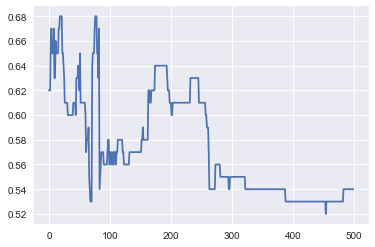

In [47]:
print("max accuracy is:")
print(max_accuracy)
print("best lambda is:")
print(max_lambda)
plt.plot(x_plot);
plt.show()

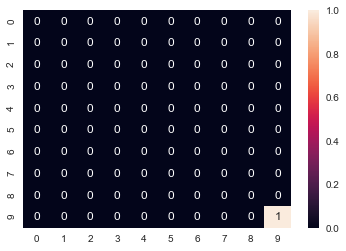

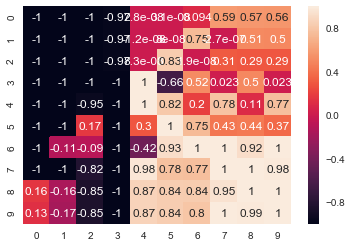

0.68


In [48]:
Rmax=1

# x=irl(state_num, action_num, probability_matrix, optimum_policy, discount, Rmax, 0.09)
# current_reward=x['x'][:state_num]
# current_reward=np.reshape(current_reward,(10,10))
# current_reward=np.transpose(current_reward)
# print(sns.heatmap(reward_1))
# print(sns.heatmap(current_reward))

ax = sns.heatmap(reward_1, annot=True)
plt.show()

ax1 = sns.heatmap(max_reward, annot=True)
plt.show()

policy_computed = val_iteration_fn(max_reward, state_space, action_set, discount)
count =0;
for i in range(10):
    for j in range(10):
        if(policy_computed[i][j]==actual_policy[i][j]):
            count+=1;
accuracy=count/100.0;
print(accuracy)

In [49]:
x_plot=[]
reward_2 = np.zeros(shape=[10,10])
reward_2[1, 4:7] = -100
reward_2[1:7, 4] = -100
reward_2[1:4, 6] = -100
reward_2[3, 6:9] = -100
reward_2[3:8, 8] = -100
reward_2[7, 6:9] = -100
reward_2[8, 6] = -100
reward_2[9,9] = 10
actual_policy=val_iteration_fn(reward_2, state_space, action_set, discount)
optimum_policy=actual_policy
Rmax=10

In [50]:
max_accuracy=0
max_lambda=0
max_reward=[]
for i in range(0,500):
    x=irl(state_num, action_num, probability_matrix, optimum_policy, discount, Rmax, i/100.0)
    current_reward=x['x'][:state_num]
    current_reward=np.reshape(current_reward,(10,10))
    current_reward=np.transpose(current_reward)
    policy_computed = val_iteration_fn(current_reward, state_space, action_set, discount)
    count =0;
    for j in range(10):
        for k in range(10):
            if(policy_computed[j][k]==actual_policy[j][k]):
                count+=1;
    accuracy=count/100.0;
    if(accuracy>max_accuracy):
        max_accuracy=accuracy
        max_lambda=i/100.0
        max_reward=current_reward
    x_plot.append(accuracy);

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  3.2585e+00 -1.1221e+03  2e+03  9e-02  8e+00  8e-01
 2: -3.4423e+01 -6.8431e+02  1e+03  5e-02  5e+00  7e-01
 3: -1.3348e+02 -4.7421e+02  8e+02  3e-02  2e+00  6e-01
 4: -2.6412e+02 -5.5468e+02  9e+02  2e-02  2e+00  6e-01
 5: -3.3301e+02 -5.6734e+02  9e+02  2e-02  2e+00  6e-01
 6: -4.3662e+02 -5.6416e+02  6e+02  1e-02  9e-01  4e-01
 7: -4.5898e+02 -5.4369e+02  4e+02  7e-03  6e-01  3e-01
 8: -5.0518e+02 -5.4344e+02  2e+02  3e-03  3e-01  2e-01
 9: -5.2242e+02 -5.4582e+02  1e+02  2e-03  2e-01  1e-01
10: -5.3535e+02 -5.4714e+02  6e+01  9e-04  8e-02  6e-02
11: -5.4424e+02 -5.4961e+02  3e+01  4e-04  4e-02  3e-02
12: -5.5033e+02 -5.5154e+02  6e+00  1e-04  9e-03  6e-03
13: -5.5066e+02 -5.5159e+02  5e+00  8e-05  7e-03  5e-03
14: -5.5129e+02 -5.5174e+02  2e+00  4e-05  3e-03  2e-03
15: -5.5182e+02 -5.5188e+02  3e-01  5e-06  4e-04  3e-04
16: -5.5188e+02 -5.5190e+02  8e-02  1e-06  1e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  9.7337e+00 -1.0915e+03  2e+03  9e-02  8e+00  8e-01
 2: -2.1860e+01 -6.5417e+02  1e+03  5e-02  5e+00  7e-01
 3: -1.0568e+02 -4.2620e+02  7e+02  3e-02  2e+00  5e-01
 4: -2.3676e+02 -5.0151e+02  8e+02  2e-02  2e+00  6e-01
 5: -3.0316e+02 -5.0262e+02  7e+02  2e-02  1e+00  5e-01
 6: -3.9234e+02 -5.0413e+02  4e+02  9e-03  8e-01  3e-01
 7: -4.0538e+02 -4.8571e+02  3e+02  6e-03  6e-01  3e-01
 8: -4.6205e+02 -4.8888e+02  1e+02  2e-03  2e-01  9e-02
 9: -4.7719e+02 -4.9123e+02  6e+01  1e-03  1e-01  5e-02
10: -4.8059e+02 -4.9103e+02  4e+01  8e-04  7e-02  4e-02
11: -4.8829e+02 -4.9321e+02  2e+01  4e-04  4e-02  2e-02
12: -4.9180e+02 -4.9410e+02  1e+01  2e-04  2e-02  1e-02
13: -4.9367e+02 -4.9474e+02  5e+00  9e-05  8e-03  4e-03
14: -4.9395e+02 -4.9480e+02  4e+00  7e-05  6e-03  4e-03
15: -4.9479e+02 -4.9507e+02  1e+00  2e-05  2e-03  1e-03
16: -4.9509e+02 -4.9517e+02  3e-01  6e-06  5e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  1.5734e+01 -1.0616e+03  2e+03  9e-02  8e+00  7e-01
 2: -1.0692e+01 -6.3222e+02  1e+03  5e-02  4e+00  6e-01
 3: -8.1733e+01 -3.8380e+02  6e+02  2e-02  2e+00  5e-01
 4: -1.7849e+02 -4.4334e+02  7e+02  2e-02  2e+00  5e-01
 5: -2.5409e+02 -4.5352e+02  6e+02  2e-02  1e+00  5e-01
 6: -3.2074e+02 -4.5355e+02  5e+02  1e-02  9e-01  4e-01
 7: -3.5775e+02 -4.4663e+02  4e+02  7e-03  6e-01  3e-01
 8: -4.0938e+02 -4.4247e+02  1e+02  3e-03  2e-01  1e-01
 9: -4.2318e+02 -4.4167e+02  8e+01  1e-03  1e-01  6e-02
10: -4.3285e+02 -4.4215e+02  4e+01  7e-04  7e-02  3e-02
11: -4.3833e+02 -4.4279e+02  2e+01  4e-04  3e-02  2e-02
12: -4.3879e+02 -4.4285e+02  2e+01  3e-04  3e-02  2e-02
13: -4.4232e+02 -4.4350e+02  5e+00  9e-05  8e-03  5e-03
14: -4.4333e+02 -4.4382e+02  2e+00  4e-05  4e-03  2e-03
15: -4.4371e+02 -4.4394e+02  1e+00  2e-05  2e-03  9e-04
16: -4.4388e+02 -4.4399e+02  4e-01  9e-06  8e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  2.1303e+01 -1.0325e+03  2e+03  8e-02  7e+00  7e-01
 2: -1.0858e+00 -6.1066e+02  1e+03  5e-02  4e+00  6e-01
 3: -6.2957e+01 -3.4442e+02  6e+02  2e-02  2e+00  4e-01
 4: -1.4501e+02 -3.9810e+02  7e+02  2e-02  2e+00  5e-01
 5: -2.1292e+02 -4.1257e+02  6e+02  2e-02  1e+00  5e-01
 6: -2.7473e+02 -4.0733e+02  5e+02  1e-02  9e-01  3e-01
 7: -3.0409e+02 -4.0295e+02  4e+02  8e-03  7e-01  3e-01
 8: -3.6001e+02 -3.9728e+02  1e+02  3e-03  3e-01  1e-01
 9: -3.8206e+02 -3.9546e+02  5e+01  1e-03  9e-02  4e-02
10: -3.9093e+02 -3.9598e+02  2e+01  4e-04  4e-02  2e-02
11: -3.9409e+02 -3.9634e+02  9e+00  2e-04  2e-02  9e-03
12: -3.9551e+02 -3.9657e+02  4e+00  9e-05  7e-03  4e-03
13: -3.9664e+02 -3.9685e+02  8e-01  2e-05  1e-03  8e-04
14: -3.9683e+02 -3.9690e+02  3e-01  5e-06  5e-04  3e-04
15: -3.9690e+02 -3.9691e+02  6e-02  1e-06  1e-04  5e-05
16: -3.9691e+02 -3.9691e+02  2e-02  4e-07  3e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  2.6903e+01 -1.0192e+03  2e+03  8e-02  7e+00  7e-01
 2:  8.8516e+00 -5.9795e+02  1e+03  5e-02  4e+00  6e-01
 3: -4.3534e+01 -3.0539e+02  5e+02  2e-02  2e+00  4e-01
 4: -1.1467e+02 -3.5328e+02  6e+02  2e-02  2e+00  5e-01
 5: -1.6830e+02 -3.6796e+02  6e+02  2e-02  1e+00  4e-01
 6: -2.2318e+02 -3.5991e+02  5e+02  1e-02  9e-01  3e-01
 7: -2.7258e+02 -3.5292e+02  3e+02  6e-03  6e-01  2e-01
 8: -2.9196e+02 -3.4249e+02  2e+02  4e-03  3e-01  2e-01
 9: -3.2527e+02 -3.4486e+02  8e+01  2e-03  1e-01  6e-02
10: -3.3812e+02 -3.4528e+02  3e+01  6e-04  5e-02  2e-02
11: -3.4362e+02 -3.4573e+02  8e+00  2e-04  1e-02  8e-03
12: -3.4588e+02 -3.4623e+02  1e+00  3e-05  2e-03  1e-03
13: -3.4626e+02 -3.4633e+02  3e-01  6e-06  5e-04  3e-04
14: -3.4633e+02 -3.4634e+02  7e-02  1e-06  1e-04  7e-05
15: -3.4635e+02 -3.4635e+02  7e-03  1e-07  1e-05  7e-06
16: -3.4635e+02 -3.4635e+02  3e-04  5e-09  5e-07  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  3.1802e+01 -1.0143e+03  2e+03  8e-02  7e+00  7e-01
 2:  1.7352e+01 -5.9088e+02  1e+03  5e-02  4e+00  6e-01
 3: -2.7342e+01 -2.7533e+02  4e+02  2e-02  2e+00  3e-01
 4: -9.1411e+01 -3.1287e+02  5e+02  2e-02  1e+00  4e-01
 5: -1.3026e+02 -3.2419e+02  6e+02  2e-02  1e+00  4e-01
 6: -1.7352e+02 -3.1789e+02  5e+02  1e-02  1e+00  3e-01
 7: -2.1893e+02 -3.0529e+02  3e+02  7e-03  6e-01  2e-01
 8: -2.3581e+02 -2.9936e+02  2e+02  5e-03  4e-01  2e-01
 9: -2.7137e+02 -2.9656e+02  1e+02  2e-03  2e-01  8e-02
10: -2.8412e+02 -2.9665e+02  5e+01  1e-03  8e-02  4e-02
11: -2.9299e+02 -2.9709e+02  2e+01  3e-04  3e-02  1e-02
12: -2.9576e+02 -2.9736e+02  6e+00  1e-04  1e-02  6e-03
13: -2.9687e+02 -2.9747e+02  2e+00  5e-05  4e-03  2e-03
14: -2.9731e+02 -2.9752e+02  8e-01  2e-05  1e-03  8e-04
15: -2.9753e+02 -2.9756e+02  1e-01  3e-06  2e-04  1e-04
16: -2.9757e+02 -2.9757e+02  2e-02  3e-07  3e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  3.6172e+01 -1.0099e+03  2e+03  8e-02  7e+00  7e-01
 2:  2.4529e+01 -5.8430e+02  1e+03  5e-02  4e+00  6e-01
 3: -1.4652e+01 -2.5175e+02  4e+02  2e-02  2e+00  3e-01
 4: -7.3923e+01 -2.7143e+02  5e+02  2e-02  1e+00  4e-01
 5: -9.9713e+01 -2.7845e+02  5e+02  1e-02  1e+00  4e-01
 6: -1.5118e+02 -2.7236e+02  4e+02  1e-02  8e-01  3e-01
 7: -1.7351e+02 -2.5725e+02  3e+02  7e-03  5e-01  2e-01
 8: -2.0515e+02 -2.5202e+02  2e+02  4e-03  3e-01  1e-01
 9: -2.2910e+02 -2.4758e+02  7e+01  1e-03  1e-01  6e-02
10: -2.4228e+02 -2.4899e+02  3e+01  5e-04  4e-02  2e-02
11: -2.4778e+02 -2.4967e+02  7e+00  2e-04  1e-02  7e-03
12: -2.4908e+02 -2.4983e+02  3e+00  6e-05  5e-03  3e-03
13: -2.4970e+02 -2.4992e+02  9e-01  2e-05  1e-03  8e-04
14: -2.4986e+02 -2.4995e+02  3e-01  7e-06  5e-04  3e-04
15: -2.4994e+02 -2.4996e+02  7e-02  2e-06  1e-04  7e-05
16: -2.4996e+02 -2.4996e+02  2e-02  4e-07  3e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  4.0045e+01 -1.0071e+03  2e+03  8e-02  7e+00  7e-01
 2:  3.0656e+01 -5.7886e+02  9e+02  5e-02  4e+00  6e-01
 3: -4.1826e+00 -2.3798e+02  4e+02  2e-02  1e+00  3e-01
 4: -6.0143e+01 -2.2168e+02  4e+02  1e-02  1e+00  3e-01
 5: -7.8093e+01 -2.2678e+02  4e+02  1e-02  9e-01  3e-01
 6: -1.1474e+02 -2.2819e+02  4e+02  9e-03  7e-01  3e-01
 7: -1.3132e+02 -2.1014e+02  3e+02  6e-03  5e-01  2e-01
 8: -1.6126e+02 -2.0901e+02  2e+02  4e-03  3e-01  1e-01
 9: -1.7449e+02 -2.0679e+02  1e+02  3e-03  2e-01  1e-01
10: -1.9653e+02 -2.0608e+02  4e+01  8e-04  6e-02  3e-02
11: -2.0195e+02 -2.0596e+02  1e+01  3e-04  3e-02  1e-02
12: -2.0454e+02 -2.0611e+02  6e+00  1e-04  1e-02  5e-03
13: -2.0543e+02 -2.0619e+02  3e+00  6e-05  5e-03  3e-03
14: -2.0617e+02 -2.0626e+02  4e-01  8e-06  6e-04  3e-04
15: -2.0626e+02 -2.0627e+02  3e-02  6e-07  5e-05  3e-05
16: -2.0627e+02 -2.0627e+02  5e-03  1e-07  9e-06  

22: -1.7515e+02 -1.7515e+02  4e-05  9e-10  7e-08  4e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  4.3087e+01 -1.0051e+03  2e+03  8e-02  6e+00  7e-01
 2:  3.5303e+01 -5.7432e+02  9e+02  5e-02  4e+00  6e-01
 3:  3.6269e+00 -2.3468e+02  4e+02  2e-02  1e+00  3e-01
 4: -2.6025e+01 -1.9693e+02  3e+02  1e-02  1e+00  3e-01
 5: -6.5972e+01 -1.9496e+02  3e+02  1e-02  8e-01  2e-01
 6: -8.2078e+01 -1.9891e+02  4e+02  9e-03  7e-01  3e-01
 7: -9.2403e+01 -1.8237e+02  3e+02  7e-03  6e-01  2e-01
 8: -1.2138e+02 -1.6986e+02  2e+02  4e-03  3e-01  1e-01
 9: -1.4269e+02 -1.6946e+02  1e+02  2e-03  2e-01  8e-02
10: -1.5594e+02 -1.6953e+02  5e+01  1e-03  8e-02  4e-02
11: -1.6345e+02 -1.6941e+02  2e+01  5e-04  4e-02  2e-02
12: -1.6835e+02 -1.6999e+02  6e+00  1e-04  1e-02  6e-03
13: -1.6939e+02 -1.7011e+02  3e+00  6e-05  4e-03  3e-03
14: -1.6991e+02 -1.7018e+02  1e+00  2e-05  2e-03  1e-03
15: -1.7013e+02 -1.7021e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  4.5839e+01 -1.0033e+03  2e+03  8e-02  6e+00  7e-01
 2:  3.9390e+01 -5.6994e+02  9e+02  5e-02  4e+00  6e-01
 3:  9.6104e+00 -2.2912e+02  4e+02  2e-02  1e+00  3e-01
 4: -8.7404e+00 -1.7742e+02  3e+02  1e-02  1e+00  2e-01
 5: -4.9091e+01 -1.5870e+02  3e+02  9e-03  7e-01  2e-01
 6: -5.0720e+01 -1.5774e+02  3e+02  9e-03  6e-01  2e-01
 7: -7.5967e+01 -1.5473e+02  2e+02  6e-03  5e-01  2e-01
 8: -8.5678e+01 -1.4546e+02  2e+02  5e-03  4e-01  1e-01
 9: -1.0070e+02 -1.3574e+02  1e+02  3e-03  2e-01  1e-01
10: -1.1749e+02 -1.3501e+02  6e+01  1e-03  1e-01  5e-02
11: -1.2131e+02 -1.3458e+02  5e+01  1e-03  8e-02  4e-02
12: -1.3113e+02 -1.3522e+02  1e+01  3e-04  2e-02  1e-02
13: -1.3319e+02 -1.3554e+02  8e+00  2e-04  1e-02  8e-03
14: -1.3449e+02 -1.3568e+02  4e+00  1e-04  7e-03  4e-03
15: -1.3546e+02 -1.3580e+02  1e+00  3e-05  2e-03  1e-03
16: -1.3566e+02 -1.3582e+02  6e-01  1e-05  1e-03  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  4.7990e+01 -1.0019e+03  2e+03  8e-02  6e+00  7e-01
 2:  4.2510e+01 -5.6628e+02  9e+02  5e-02  4e+00  6e-01
 3:  1.3674e+01 -2.2284e+02  4e+02  2e-02  1e+00  2e-01
 4: -1.0917e-01 -1.6008e+02  3e+02  1e-02  9e-01  2e-01
 5: -3.4603e+01 -1.2360e+02  2e+02  7e-03  5e-01  2e-01
 6: -4.1633e+01 -1.2293e+02  2e+02  7e-03  5e-01  2e-01
 7: -5.2834e+01 -1.2539e+02  2e+02  6e-03  4e-01  2e-01
 8: -7.4278e+01 -1.1770e+02  1e+02  3e-03  3e-01  1e-01
 9: -8.9750e+01 -1.1087e+02  7e+01  2e-03  1e-01  5e-02
10: -9.5460e+01 -1.0773e+02  4e+01  1e-03  7e-02  4e-02
11: -1.0208e+02 -1.0697e+02  2e+01  4e-04  3e-02  2e-02
12: -1.0485e+02 -1.0721e+02  8e+00  2e-04  1e-02  8e-03
13: -1.0663e+02 -1.0736e+02  2e+00  6e-05  4e-03  2e-03
14: -1.0720e+02 -1.0738e+02  6e-01  1e-05  1e-03  6e-04
15: -1.0731e+02 -1.0739e+02  3e-01  6e-06  5e-04  3e-04
16: -1.0737e+02 -1.0739e+02  6e-02  2e-06  1e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  5.0277e+01 -1.0006e+03  2e+03  8e-02  6e+00  7e-01
 2:  4.6183e+01 -5.6513e+02  9e+02  5e-02  3e+00  6e-01
 3:  1.8078e+01 -2.1469e+02  3e+02  2e-02  1e+00  2e-01
 4:  6.1208e+00 -1.3620e+02  2e+02  1e-02  8e-01  2e-01
 5: -1.4599e+01 -9.7972e+01  2e+02  7e-03  5e-01  1e-01
 6: -3.0475e+01 -1.0202e+02  2e+02  6e-03  4e-01  1e-01
 7: -3.2824e+01 -9.7997e+01  2e+02  5e-03  4e-01  1e-01
 8: -4.5638e+01 -9.0392e+01  1e+02  4e-03  3e-01  1e-01
 9: -5.7229e+01 -8.5536e+01  8e+01  2e-03  2e-01  7e-02
10: -6.5227e+01 -8.1481e+01  5e+01  1e-03  9e-02  4e-02
11: -7.2137e+01 -7.9212e+01  2e+01  6e-04  4e-02  2e-02
12: -7.4730e+01 -7.8636e+01  1e+01  3e-04  2e-02  1e-02
13: -7.7076e+01 -7.8285e+01  4e+00  1e-04  7e-03  4e-03
14: -7.7859e+01 -7.8225e+01  1e+00  3e-05  2e-03  1e-03
15: -7.8086e+01 -7.8209e+01  4e-01  1e-05  7e-04  4e-04
16: -7.8164e+01 -7.8204e+01  1e-01  3e-06  2e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  5.2348e+01 -9.9944e+02  2e+03  8e-02  6e+00  7e-01
 2:  4.9890e+01 -5.6649e+02  9e+02  5e-02  3e+00  6e-01
 3:  2.1771e+01 -2.0555e+02  3e+02  2e-02  1e+00  2e-01
 4:  9.9448e+00 -1.0979e+02  2e+02  1e-02  6e-01  1e-01
 5: -2.0785e+00 -7.6933e+01  1e+02  6e-03  4e-01  1e-01
 6: -1.6183e+01 -7.5895e+01  1e+02  5e-03  3e-01  1e-01
 7: -1.5532e+01 -7.0876e+01  1e+02  4e-03  3e-01  1e-01
 8: -1.9949e+01 -6.7014e+01  1e+02  4e-03  3e-01  1e-01
 9: -3.3838e+01 -6.0287e+01  7e+01  2e-03  1e-01  6e-02
10: -4.1156e+01 -5.5281e+01  4e+01  1e-03  8e-02  3e-02
11: -4.8402e+01 -5.2905e+01  1e+01  4e-04  2e-02  1e-02
12: -4.9715e+01 -5.2462e+01  8e+00  2e-04  1e-02  7e-03
13: -5.1418e+01 -5.2149e+01  2e+00  6e-05  4e-03  2e-03
14: -5.1813e+01 -5.2076e+01  8e-01  2e-05  1e-03  7e-04
15: -5.1966e+01 -5.2056e+01  3e-01  7e-06  5e-04  3e-04
16: -5.2026e+01 -5.2048e+01  7e-02  2e-06  1e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.4224e+01 -9.9845e+02  2e+03  8e-02  6e+00  7e-01
 2:  5.3313e+01 -5.6763e+02  9e+02  5e-02  3e+00  6e-01
 3:  2.5022e+01 -1.9529e+02  3e+02  2e-02  1e+00  2e-01
 4:  1.2584e+01 -8.2311e+01  1e+02  8e-03  5e-01  1e-01
 5:  5.8398e+00 -5.6434e+01  1e+02  5e-03  3e-01  9e-02
 6: -7.2925e+00 -4.0085e+01  7e+01  3e-03  2e-01  7e-02
 7: -7.3942e+00 -3.9044e+01  7e+01  3e-03  2e-01  7e-02
 8: -1.1417e+01 -3.7880e+01  6e+01  2e-03  1e-01  6e-02
 9: -1.4070e+01 -3.5530e+01  5e+01  2e-03  1e-01  5e-02
10: -1.9534e+01 -3.3707e+01  4e+01  1e-03  7e-02  3e-02
11: -2.0227e+01 -3.2765e+01  3e+01  1e-03  7e-02  3e-02
12: -2.5279e+01 -3.0873e+01  1e+01  4e-04  3e-02  1e-02
13: -2.6242e+01 -3.0289e+01  1e+01  3e-04  2e-02  1e-02
14: -2.6710e+01 -3.0118e+01  9e+00  3e-04  2e-02  9e-03
15: -2.8878e+01 -2.9625e+01  2e+00  6e-05  4e-03  2e-03
16: -2.9255e+01 -2.9518e+01  7e-01  2e-05  1e-03  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.5921e+01 -9.9762e+02  2e+03  8e-02  5e+00  7e-01
 2:  5.6485e+01 -5.6858e+02  9e+02  5e-02  3e+00  6e-01
 3:  2.8243e+01 -1.8417e+02  3e+02  2e-02  1e+00  2e-01
 4:  1.3722e+01 -5.3858e+01  1e+02  5e-03  3e-01  9e-02
 5:  9.7103e+00 -3.4096e+01  7e+01  4e-03  2e-01  7e-02
 6:  2.6833e+00 -1.7745e+01  4e+01  2e-03  1e-01  4e-02
 7: -1.3832e+00 -1.7106e+01  4e+01  1e-03  8e-02  3e-02
 8: -1.1988e+00 -1.6133e+01  3e+01  1e-03  8e-02  3e-02
 9: -3.3804e+00 -1.4510e+01  2e+01  9e-04  6e-02  2e-02
10: -3.9604e+00 -1.3928e+01  2e+01  8e-04  5e-02  2e-02
11: -4.2135e+00 -1.2737e+01  2e+01  7e-04  4e-02  2e-02
12: -5.4788e+00 -1.2030e+01  2e+01  5e-04  3e-02  1e-02
13: -6.0321e+00 -1.1512e+01  1e+01  4e-04  3e-02  1e-02
14: -7.7333e+00 -1.0890e+01  8e+00  3e-04  2e-02  7e-03
15: -7.7412e+00 -1.0882e+01  8e+00  3e-04  2e-02  7e-03
16: -8.8300e+00 -1.0346e+01  4e+00  1e-04  8e-03  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.7664e+01 -9.9683e+02  2e+03  8e-02  5e+00  7e-01
 2:  5.9837e+01 -5.6942e+02  9e+02  5e-02  3e+00  6e-01
 3:  3.1414e+01 -1.7015e+02  3e+02  2e-02  1e+00  2e-01
 4:  1.5859e+01 -4.4944e+01  9e+01  5e-03  3e-01  8e-02
 5:  9.6009e+00 -1.9771e+01  4e+01  2e-03  1e-01  4e-02
 6:  3.1496e+00 -3.0500e+00  8e+00  5e-04  3e-02  8e-03
 7:  6.8828e-01 -3.5928e-01  1e+00  8e-05  5e-03  1e-03
 8:  1.2185e-01 -4.0495e-02  2e-01  1e-05  8e-04  2e-04
 9:  1.2873e-03 -4.2228e-04  2e-03  1e-07  8e-06  2e-06
10:  1.2872e-05 -4.2223e-06  2e-05  1e-09  8e-08  2e-08
11:  1.2872e-07 -4.2223e-08  2e-07  1e-11  8e-10  2e-10
12:  1.2872e-09 -4.2223e-10  2e-09  1e-13  1e-11  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.7868e+01 -9.9675e+02  2e+03  8e-02  5e+00  7e-01
 2:  6.0237e+01 -5.6951e+02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.9930e+01 -9.9594e+02  2e+03  8e-02  5e+00  7e-01
 2:  6.4387e+01 -5.7028e+02  9e+02  5e-02  3e+00  6e-01
 3:  3.6058e+01 -1.5763e+02  3e+02  2e-02  9e-01  2e-01
 4:  1.7469e+01 -4.0012e+01  8e+01  5e-03  3e-01  7e-02
 5:  5.5918e+00 -6.9679e+00  2e+01  1e-03  6e-02  1e-02
 6:  5.7220e-01 -1.2773e-01  8e-01  6e-05  3e-03  8e-04
 7:  5.9178e-03 -1.3206e-03  8e-03  6e-07  3e-05  8e-06
 8:  5.9171e-05 -1.3204e-05  8e-05  6e-09  3e-07  8e-08
 9:  5.9171e-07 -1.3204e-07  8e-07  6e-11  3e-09  8e-10
10:  5.9171e-09 -1.3204e-09  8e-09  6e-13  3e-11  8e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.0101e+01 -9.9587e+02  2e+03  8e-02  5e+00  7e-01
 2:  6.4743e+01 -5.7032e+02  1e+03  5e-02  3e+00  6e-01
 3:  3.6478e+01 -1.5757e+02  3e+02  2e-02  9e-01  2e-01
 4:  1.7486e+01 -3.9553e+01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.1832e+01 -9.9532e+02  2e+03  8e-02  5e+00  7e-01
 2:  6.8447e+01 -5.7067e+02  1e+03  5e-02  3e+00  6e-01
 3:  4.0752e+01 -1.5668e+02  3e+02  2e-02  9e-01  2e-01
 4:  1.6454e+01 -3.1054e+01  6e+01  4e-03  2e-01  5e-02
 5:  3.1603e+00 -2.7043e+00  7e+00  5e-04  3e-02  6e-03
 6:  6.0179e-02 -2.8035e-02  1e-01  7e-06  4e-04  9e-05
 7:  6.0145e-04 -2.8019e-04  1e-03  7e-08  4e-06  9e-07
 8:  6.0144e-06 -2.8018e-06  1e-05  7e-10  4e-08  9e-09
 9:  6.0144e-08 -2.8018e-08  1e-07  7e-12  4e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.1976e+01 -9.9528e+02  2e+03  8e-02  5e+00  7e-01
 2:  6.8766e+01 -5.7068e+02  1e+03  5e-02  3e+00  6e-01
 3:  4.1112e+01 -1.5658e+02  3e+02  2e-02  8e-01  2e-01
 4:  1.6275e+01 -3.0106e+01  6e+01  4e-03  2e-01  5e-02
 5:  2.9889e+00 -2.4963e+00 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.3544e+01 -9.9490e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.2380e+01 -5.7061e+02  1e+03  5e-02  3e+00  6e-01
 3:  4.5106e+01 -1.5503e+02  3e+02  2e-02  8e-01  2e-01
 4:  1.5656e+01 -2.3121e+01  5e+01  3e-03  2e-01  4e-02
 5:  1.6280e+00 -9.6747e-01  3e+00  2e-04  1e-02  2e-03
 6:  1.6925e-02 -9.8247e-03  3e-02  2e-06  1e-04  3e-05
 7:  1.6923e-04 -9.8231e-05  3e-04  2e-08  1e-06  3e-07
 8:  1.6923e-06 -9.8231e-07  3e-06  2e-10  1e-08  3e-09
 9:  1.6923e-08 -9.8231e-09  3e-08  2e-12  1e-10  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.3662e+01 -9.9488e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.2664e+01 -5.7058e+02  1e+03  5e-02  3e+00  6e-01
 3:  4.5414e+01 -1.5488e+02  3e+02  2e-02  8e-01  2e-01
 4:  1.5619e+01 -2.2655e+01  5e+01  3e-03  2e-01  4e-02
 5:  1.5463e+00 -8.9882e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.4948e+01 -9.9469e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.5903e+01 -5.7009e+02  1e+03  5e-02  2e+00  6e-01
 3:  4.8854e+01 -1.5288e+02  3e+02  2e-02  8e-01  2e-01
 4:  1.4846e+01 -1.7360e+01  4e+01  3e-03  1e-01  3e-02
 5:  8.0487e-01 -3.9327e-01  1e+00  1e-04  5e-03  1e-03
 6:  8.0532e-03 -3.9339e-03  1e-02  1e-06  5e-05  1e-05
 7:  8.0527e-05 -3.9336e-05  1e-04  1e-08  5e-07  1e-07
 8:  8.0527e-07 -3.9336e-07  1e-06  1e-10  5e-09  1e-09
 9:  8.0527e-09 -3.9336e-09  1e-08  1e-12  5e-11  1e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.5045e+01 -9.9469e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.6159e+01 -5.7003e+02  1e+03  5e-02  2e+00  6e-01
 3:  4.9121e+01 -1.5269e+02  3e+02  2e-02  8e-01  2e-01
 4:  1.4758e+01 -1.6948e+01  4e+01  3e-03  1e-01  3e-02
 5:  7.6077e-01 -3.6878e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.6090e+01 -9.9465e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.9078e+01 -5.6914e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.2115e+01 -1.5035e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.3522e+01 -1.2401e+01  3e+01  2e-03  9e-02  3e-02
 5:  3.9014e-01 -1.6993e-01  6e-01  4e-05  2e-03  6e-04
 6:  3.8961e-03 -1.6970e-03  6e-03  4e-07  2e-05  6e-06
 7:  3.8961e-05 -1.6970e-05  6e-05  4e-09  2e-07  6e-08
 8:  3.8961e-07 -1.6970e-07  6e-07  4e-11  2e-09  6e-10
 9:  3.8961e-09 -1.6970e-09  6e-09  4e-13  2e-11  6e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.6169e+01 -9.9465e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.9309e+01 -5.6905e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.2349e+01 -1.5014e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.3407e+01 -1.2058e+01  3e+01  2e-03  9e-02  3e-02
 5:  3.6974e-01 -1.6071e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.7011e+01 -9.9472e+02  2e+03  8e-02  4e+00  7e-01
 2:  8.1957e+01 -5.6778e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.4977e+01 -1.4754e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.2543e+01 -1.0297e+01  3e+01  2e-03  8e-02  2e-02
 5:  2.5916e-01 -1.2502e-01  4e-01  3e-05  1e-03  4e-04
 6:  2.5893e-03 -1.2491e-03  4e-03  3e-07  1e-05  4e-06
 7:  2.5892e-05 -1.2491e-05  4e-05  3e-09  1e-07  4e-08
 8:  2.5892e-07 -1.2491e-07  4e-07  3e-11  1e-09  4e-10
 9:  2.5892e-09 -1.2491e-09  4e-09  3e-13  1e-11  4e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  9e+00  1e+00
 1:  6.7073e+01 -9.9473e+02  2e+03  8e-02  4e+00  7e-01
 2:  8.2167e+01 -5.6766e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.5183e+01 -1.4731e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.2502e+01 -1.0286e+01  3e+01  2e-03  8e-02  2e-02
 5:  2.5471e-01 -1.2422e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  9e+00  1e+00
 1:  6.7741e+01 -9.9489e+02  2e+03  9e-02  3e+00  7e-01
 2:  8.4582e+01 -5.6604e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.7505e+01 -1.4450e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.1915e+01 -1.0004e+01  3e+01  2e-03  7e-02  2e-02
 5:  2.0665e-01 -1.1480e-01  4e-01  3e-05  1e-03  4e-04
 6:  2.0649e-03 -1.1472e-03  4e-03  3e-07  1e-05  4e-06
 7:  2.0649e-05 -1.1472e-05  4e-05  3e-09  1e-07  4e-08
 8:  2.0649e-07 -1.1472e-07  4e-07  3e-11  1e-09  4e-10
 9:  2.0649e-09 -1.1472e-09  4e-09  3e-13  1e-11  4e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  9e+00  1e+00
 1:  6.7791e+01 -9.9491e+02  2e+03  9e-02  3e+00  7e-01
 2:  8.4774e+01 -5.6590e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.7687e+01 -1.4426e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.1858e+01 -9.9708e+00  3e+01  2e-03  7e-02  2e-02
 5:  2.0309e-01 -1.1403e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  9e+00  1e+00
 1:  6.8311e+01 -9.9512e+02  2e+03  9e-02  3e+00  7e-01
 2:  8.6988e+01 -5.6396e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.9749e+01 -1.4128e+02  3e+02  2e-02  6e-01  2e-01
 4:  1.1128e+01 -9.4913e+00  2e+01  2e-03  6e-02  2e-02
 5:  1.6577e-01 -1.0481e-01  3e-01  2e-05  8e-04  3e-04
 6:  1.6568e-03 -1.0475e-03  3e-03  2e-07  8e-06  3e-06
 7:  1.6568e-05 -1.0475e-05  3e-05  2e-09  8e-08  3e-08
 8:  1.6568e-07 -1.0475e-07  3e-07  2e-11  8e-10  3e-10
 9:  1.6568e-09 -1.0475e-09  3e-09  2e-13  8e-12  3e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  9e+00  1e+00
 1:  6.8349e+01 -9.9514e+02  2e+03  9e-02  3e+00  7e-01
 2:  8.7164e+01 -5.6378e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.9911e+01 -1.4103e+02  3e+02  2e-02  6e-01  2e-01
 4:  1.1063e+01 -9.4461e+00  2e+01  2e-03  6e-02  2e-02
 5:  1.6308e-01 -1.0405e-01 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.8742e+01 -9.9540e+02  2e+03  9e-02  3e+00  7e-01
 2:  8.9204e+01 -5.6154e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.1748e+01 -1.3790e+02  3e+02  2e-02  6e-01  2e-01
 4:  1.0261e+01 -8.8623e+00  2e+01  2e-03  6e-02  2e-02
 5:  1.3517e-01 -9.5109e-02  3e-01  2e-05  7e-04  2e-04
 6:  1.3511e-03 -9.5067e-04  3e-03  2e-07  7e-06  2e-06
 7:  1.3511e-05 -9.5067e-06  3e-05  2e-09  7e-08  2e-08
 8:  1.3511e-07 -9.5067e-08  3e-07  2e-11  7e-10  2e-10
 9:  1.3511e-09 -9.5067e-10  3e-09  2e-13  7e-12  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.8770e+01 -9.9542e+02  2e+03  9e-02  3e+00  7e-01
 2:  8.9367e+01 -5.6134e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.1893e+01 -1.3764e+02  3e+02  2e-02  6e-01  2e-01
 4:  1.0193e+01 -8.8109e+00  2e+01  2e-03  6e-02  2e-02
 5:  1.3317e-01 -9.4380e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.9055e+01 -9.9570e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.1256e+01 -5.5882e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.3531e+01 -1.3438e+02  3e+02  2e-02  6e-01  3e-01
 4:  9.3668e+00 -8.1731e+00  2e+01  1e-03  5e-02  2e-02
 5:  1.1242e-01 -8.5835e-02  2e-01  2e-05  6e-04  2e-04
 6:  1.1238e-03 -8.5805e-04  2e-03  2e-07  6e-06  2e-06
 7:  1.1238e-05 -8.5804e-06  2e-05  2e-09  6e-08  2e-08
 8:  1.1238e-07 -8.5804e-08  2e-07  2e-11  6e-10  2e-10
 9:  1.1238e-09 -8.5804e-10  2e-09  2e-13  6e-12  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.9075e+01 -9.9572e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.1408e+01 -5.5860e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.3660e+01 -1.3410e+02  3e+02  2e-02  5e-01  3e-01
 4:  9.2979e+00 -8.1184e+00  2e+01  1e-03  5e-02  2e-02
 5:  1.1093e-01 -8.5139e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9267e+01 -9.9601e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.3164e+01 -5.5583e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.5122e+01 -1.3072e+02  3e+02  2e-02  5e-01  3e-01
 4:  8.4772e+00 -7.4504e+00  2e+01  1e-03  4e-02  2e-02
 5:  9.5179e-02 -7.6978e-02  2e-01  1e-05  5e-04  2e-04
 6:  9.5152e-04 -7.6956e-04  2e-03  1e-07  5e-06  2e-06
 7:  9.5152e-06 -7.6956e-06  2e-05  1e-09  5e-08  2e-08
 8:  9.5152e-08 -7.6956e-08  2e-07  1e-11  5e-10  2e-10
 9:  9.5152e-10 -7.6956e-10  2e-09  1e-13  5e-12  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9280e+01 -9.9604e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.3306e+01 -5.5559e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.5236e+01 -1.3043e+02  3e+02  2e-02  5e-01  3e-01
 4:  8.4096e+00 -7.3938e+00  2e+01  1e-03  4e-02  2e-02
 5:  9.4025e-02 -7.6312e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9393e+01 -9.9633e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.4946e+01 -5.5259e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.6539e+01 -1.2693e+02  3e+02  2e-02  5e-01  3e-01
 4:  7.3735e+00 -5.6808e+00  2e+01  1e-03  3e-02  1e-02
 5:  7.8002e-02 -5.8358e-02  2e-01  1e-05  3e-04  2e-04
 6:  7.7985e-04 -5.8346e-04  2e-03  1e-07  3e-06  2e-06
 7:  7.7984e-06 -5.8346e-06  2e-05  1e-09  3e-08  2e-08
 8:  7.7984e-08 -5.8346e-08  2e-07  1e-11  3e-10  2e-10
 9:  7.7984e-10 -5.8346e-10  2e-09  1e-13  3e-12  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9399e+01 -9.9635e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.5078e+01 -5.5233e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.6641e+01 -1.2663e+02  3e+02  2e-02  5e-01  3e-01
 4:  7.2839e+00 -5.5321e+00  2e+01  1e-03  3e-02  1e-02
 5:  7.6818e-02 -5.6835e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9444e+01 -9.9663e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.6617e+01 -5.4912e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.7798e+01 -1.2300e+02  3e+02  2e-02  5e-01  3e-01
 4:  6.4392e+00 -4.2889e+00  1e+01  9e-04  3e-02  1e-02
 5:  6.6357e-02 -4.3956e-02  1e-01  9e-06  3e-04  1e-04
 6:  6.6345e-04 -4.3948e-04  1e-03  9e-08  3e-06  1e-06
 7:  6.6345e-06 -4.3948e-06  1e-05  9e-10  3e-08  1e-08
 8:  6.6345e-08 -4.3948e-08  1e-07  9e-12  3e-10  1e-10
 9:  6.6345e-10 -4.3948e-10  1e-09  9e-14  3e-12  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9445e+01 -9.9666e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.6741e+01 -5.4884e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.7889e+01 -1.2269e+02  3e+02  2e-02  5e-01  3e-01
 4:  6.3902e+00 -4.2318e+00  1e+01  9e-04  3e-02  1e-02
 5:  6.5787e-02 -4.3359e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9432e+01 -9.9692e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.8188e+01 -5.4545e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.8954e+01 -1.1952e+02  3e+02  2e-02  4e-01  3e-01
 4:  5.8347e+00 -3.6085e+00  1e+01  8e-04  2e-02  1e-02
 5:  5.9504e-02 -3.6832e-02  1e-01  8e-06  2e-04  1e-04
 6:  5.9495e-04 -3.6827e-04  1e-03  8e-08  2e-06  1e-06
 7:  5.9495e-06 -3.6827e-06  1e-05  8e-10  2e-08  1e-08
 8:  5.9495e-08 -3.6827e-08  1e-07  8e-12  2e-10  1e-10
 9:  5.9495e-10 -3.6827e-10  1e-09  8e-14  2e-12  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9428e+01 -9.9694e+02  2e+03  9e-02  2e+00  7e-01
 2:  9.8305e+01 -5.4516e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.9051e+01 -1.1945e+02  3e+02  2e-02  4e-01  3e-01
 4:  5.7985e+00 -3.5674e+00  1e+01  7e-04  2e-02  1e-02
 5:  5.9101e-02 -3.6401e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9365e+01 -9.9719e+02  2e+03  9e-02  2e+00  6e-01
 2:  9.9672e+01 -5.4161e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.0150e+01 -1.1836e+02  3e+02  2e-02  4e-01  3e-01
 4:  5.3507e+00 -3.0776e+00  1e+01  7e-04  2e-02  1e-02
 5:  5.4204e-02 -3.1279e-02  1e-01  7e-06  2e-04  1e-04
 6:  5.4197e-04 -3.1275e-04  1e-03  7e-08  2e-06  1e-06
 7:  5.4197e-06 -3.1275e-06  1e-05  7e-10  2e-08  1e-08
 8:  5.4197e-08 -3.1275e-08  1e-07  7e-12  2e-10  1e-10
 9:  5.4197e-10 -3.1275e-10  1e-09  7e-14  2e-12  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9358e+01 -9.9721e+02  2e+03  9e-02  2e+00  6e-01
 2:  9.9782e+01 -5.4131e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.0236e+01 -1.1825e+02  3e+02  2e-02  4e-01  3e-01
 4:  5.3126e+00 -3.0376e+00  1e+01  7e-04  2e-02  1e-02
 5:  5.3794e-02 -3.0862e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9241e+01 -9.9744e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0118e+02 -5.3730e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.1283e+01 -1.1654e+02  3e+02  2e-02  4e-01  3e-01
 4:  4.9008e+00 -2.6882e+00  9e+00  6e-04  2e-02  9e-03
 5:  4.9432e-02 -2.7215e-02  9e-02  6e-06  2e-04  9e-05
 6:  4.9427e-04 -2.7212e-04  9e-04  6e-08  2e-06  9e-07
 7:  4.9427e-06 -2.7212e-06  9e-06  6e-10  2e-08  9e-09
 8:  4.9427e-08 -2.7212e-08  9e-08  6e-12  2e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9231e+01 -9.9746e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0128e+02 -5.3699e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.1358e+01 -1.1639e+02  3e+02  2e-02  4e-01  3e-01
 4:  4.8913e+00 -2.7008e+00  9e+00  6e-04  2e-02  9e-03
 5:  4.9339e-02 -2.7342e-02  9e-02  6e-06  2e-04  9e-05
 6:  4.9334e-04 -2.7339e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9059e+01 -9.9767e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0270e+02 -5.3252e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.2336e+01 -1.1402e+02  3e+02  1e-02  4e-01  3e-01
 4:  4.7291e+00 -2.8240e+00  9e+00  6e-04  2e-02  9e-03
 5:  4.7705e-02 -2.8558e-02  9e-02  6e-06  2e-04  9e-05
 6:  4.7701e-04 -2.8555e-04  9e-04  6e-08  2e-06  9e-07
 7:  4.7701e-06 -2.8555e-06  9e-06  6e-10  2e-08  9e-09
 8:  4.7701e-08 -2.8555e-08  9e-08  6e-12  2e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9045e+01 -9.9768e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0280e+02 -5.3219e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.2400e+01 -1.1383e+02  3e+02  1e-02  4e-01  3e-01
 4:  4.7156e+00 -2.8293e+00  9e+00  6e-04  2e-02  9e-03
 5:  4.7567e-02 -2.8608e-02  9e-02  6e-06  2e-04  9e-05
 6:  4.7562e-04 -2.8606e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.8833e+01 -9.9785e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0414e+02 -5.2759e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3240e+01 -1.1097e+02  3e+02  1e-02  4e-01  3e-01
 4:  4.5036e+00 -2.8599e+00  9e+00  6e-04  1e-02  9e-03
 5:  4.5383e-02 -2.8869e-02  9e-02  6e-06  1e-04  9e-05
 6:  4.5379e-04 -2.8866e-04  9e-04  6e-08  1e-06  9e-07
 7:  4.5379e-06 -2.8866e-06  9e-06  6e-10  1e-08  9e-09
 8:  4.5379e-08 -2.8866e-08  9e-08  6e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.8816e+01 -9.9786e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0424e+02 -5.2726e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3295e+01 -1.1075e+02  3e+02  1e-02  4e-01  3e-01
 4:  4.4870e+00 -2.8592e+00  9e+00  6e-04  1e-02  9e-03
 5:  4.5212e-02 -2.8858e-02  9e-02  6e-06  1e-04  9e-05
 6:  4.5208e-04 -2.8855e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.8571e+01 -9.9798e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0551e+02 -5.2255e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4011e+01 -1.0746e+02  3e+02  1e-02  3e-01  3e-01
 4:  4.2384e+00 -2.8163e+00  9e+00  6e-04  1e-02  9e-03
 5:  4.2639e-02 -2.8368e-02  9e-02  6e-06  1e-04  9e-05
 6:  4.2636e-04 -2.8366e-04  9e-04  6e-08  1e-06  9e-07
 7:  4.2636e-06 -2.8365e-06  9e-06  6e-10  1e-08  9e-09
 8:  4.2636e-08 -2.8365e-08  9e-08  6e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.8552e+01 -9.9799e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0559e+02 -5.2222e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4058e+01 -1.0721e+02  3e+02  1e-02  3e-01  3e-01
 4:  4.2196e+00 -2.8110e+00  9e+00  6e-04  1e-02  9e-03
 5:  4.2445e-02 -2.8311e-02  9e-02  6e-06  1e-04  9e-05
 6:  4.2442e-04 -2.8308e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.8279e+01 -9.9806e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0680e+02 -5.1743e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4663e+01 -1.0351e+02  3e+02  1e-02  3e-01  3e-01
 4:  3.9493e+00 -2.7089e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.9656e-02 -2.7227e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.9654e-04 -2.7225e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.9654e-06 -2.7225e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.9654e-08 -2.7225e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.8259e+01 -9.9806e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0688e+02 -5.1708e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4703e+01 -1.0323e+02  3e+02  1e-02  3e-01  3e-01
 4:  3.9382e+00 -2.6902e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.9539e-02 -2.7035e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.9537e-04 -2.7033e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7963e+01 -9.9808e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0802e+02 -5.1224e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.5209e+01 -9.9166e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.8164e+00 -2.3888e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.8245e-02 -2.3967e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.8242e-04 -2.3965e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.8242e-06 -2.3965e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.8242e-08 -2.3965e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7942e+01 -9.9808e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0810e+02 -5.1189e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.5242e+01 -9.8863e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.8114e+00 -2.3639e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.8190e-02 -2.3715e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.8187e-04 -2.3713e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7628e+01 -9.9805e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0868e+02 -5.1294e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4968e+01 -9.7383e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.7558e+00 -2.2525e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.7594e-02 -2.2574e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.7592e-04 -2.2572e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.7592e-06 -2.2572e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.7592e-08 -2.2572e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7605e+01 -9.9804e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0872e+02 -5.1304e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4940e+01 -9.7274e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.7722e+00 -2.2724e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.7758e-02 -2.2773e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.7756e-04 -2.2772e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7277e+01 -9.9796e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0921e+02 -5.1422e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4462e+01 -9.5548e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.9828e+00 -2.5187e+00  8e+00  5e-04  1e-02  1e-02
 5:  3.9858e-02 -2.5232e-02  8e-02  5e-06  1e-04  1e-04
 6:  3.9856e-04 -2.5230e-04  8e-04  5e-08  1e-06  1e-06
 7:  3.9856e-06 -2.5230e-06  8e-06  5e-10  1e-08  1e-08
 8:  3.9856e-08 -2.5230e-08  8e-08  5e-12  1e-10  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7253e+01 -9.9795e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0924e+02 -5.1429e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4423e+01 -9.5411e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.9965e+00 -2.5341e+00  8e+00  5e-04  1e-02  1e-02
 5:  3.9994e-02 -2.5385e-02  8e-02  5e-06  1e-04  1e-04
 6:  3.9992e-04 -2.5383e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6914e+01 -9.9781e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0968e+02 -5.1526e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4030e+01 -9.5986e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.6607e+00 -2.4462e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.6598e-02 -2.4475e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.6596e-04 -2.4473e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.6596e-06 -2.4473e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.6596e-08 -2.4473e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6889e+01 -9.9780e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0971e+02 -5.1532e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4012e+01 -9.6189e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.6095e+00 -2.4240e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.6083e-02 -2.4250e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.6081e-04 -2.4249e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6541e+01 -9.9761e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1010e+02 -5.1609e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3691e+01 -9.8524e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.0547e+00 -2.1866e+00  7e+00  4e-04  8e-03  8e-03
 5:  3.0511e-02 -2.1852e-02  7e-02  4e-06  8e-05  8e-05
 6:  3.0509e-04 -2.1851e-04  7e-04  4e-08  8e-07  8e-07
 7:  3.0509e-06 -2.1851e-06  7e-06  4e-10  8e-09  8e-09
 8:  3.0509e-08 -2.1851e-08  7e-08  4e-12  8e-11  8e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6516e+01 -9.9759e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1013e+02 -5.1614e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3663e+01 -9.8658e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.0237e+00 -2.1734e+00  7e+00  4e-04  8e-03  7e-03
 5:  3.0200e-02 -2.1719e-02  7e-02  4e-06  8e-05  7e-05
 6:  3.0198e-04 -2.1718e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6161e+01 -9.9735e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1047e+02 -5.1673e+02  1e+03  5e-02  9e-01  6e-01
 3:  7.3202e+01 -1.0010e+02  2e+02  1e-02  3e-01  3e-01
 4:  2.6948e+00 -2.0526e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6904e-02 -2.0500e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6903e-04 -2.0500e-04  6e-04  4e-08  7e-07  7e-07
 7:  2.6903e-06 -2.0500e-06  6e-06  4e-10  7e-09  7e-09
 8:  2.6903e-08 -2.0500e-08  6e-08  4e-12  7e-11  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6135e+01 -9.9733e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1049e+02 -5.1677e+02  1e+03  5e-02  9e-01  6e-01
 3:  7.3165e+01 -1.0018e+02  2e+02  1e-02  3e-01  3e-01
 4:  2.6964e+00 -2.0631e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6920e-02 -2.0605e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6919e-04 -2.0604e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.5776e+01 -9.9703e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1079e+02 -5.1721e+02  1e+03  5e-02  9e-01  7e-01
 3:  7.2588e+01 -1.0088e+02  3e+02  1e-02  3e-01  3e-01
 4:  2.6938e+00 -2.1778e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6889e-02 -2.1744e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6888e-04 -2.1743e-04  6e-04  4e-08  7e-07  7e-07
 7:  2.6888e-06 -2.1743e-06  6e-06  4e-10  7e-09  7e-09
 8:  2.6888e-08 -2.1743e-08  6e-08  4e-12  7e-11  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.5750e+01 -9.9701e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1081e+02 -5.1723e+02  1e+03  5e-02  9e-01  7e-01
 3:  7.2544e+01 -1.0090e+02  3e+02  1e-02  3e-01  3e-01
 4:  2.6919e+00 -2.1838e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6870e-02 -2.1803e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6869e-04 -2.1803e-04 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.5387e+01 -9.9667e+02  2e+03  8e-02  2e+00  6e-01
 2:  1.1108e+02 -5.1752e+02  1e+03  5e-02  9e-01  7e-01
 3:  7.1869e+01 -1.0099e+02  3e+02  1e-02  2e-01  3e-01
 4:  2.6461e+00 -2.2391e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6413e-02 -2.2353e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6412e-04 -2.2353e-04  6e-04  4e-08  7e-07  7e-07
 7:  2.6412e-06 -2.2353e-06  6e-06  4e-10  7e-09  7e-09
 8:  2.6412e-08 -2.2353e-08  6e-08  4e-12  7e-11  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.5361e+01 -9.9664e+02  2e+03  8e-02  2e+00  6e-01
 2:  1.1110e+02 -5.1753e+02  1e+03  5e-02  9e-01  7e-01
 3:  7.1818e+01 -1.0098e+02  3e+02  1e-02  2e-01  3e-01
 4:  2.6416e+00 -2.2411e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6367e-02 -2.2374e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6366e-04 -2.2373e-04 

max accuracy is:
0.79
best lambda is:
4.12


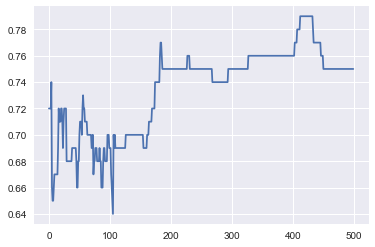

In [51]:
print("max accuracy is:")
print(max_accuracy)
print("best lambda is:")
print(max_lambda)
plt.plot(x_plot);
plt.show()

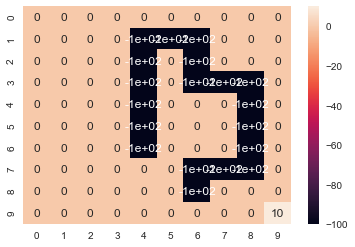

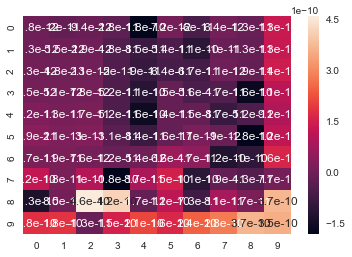

[[2. 1. 2. 1. 3. 0. 3. 3. 3. 2.]
 [2. 2. 2. 1. 1. 0. 3. 3. 3. 2.]
 [2. 2. 2. 1. 1. 2. 3. 3. 3. 3.]
 [2. 2. 2. 1. 3. 2. 2. 0. 3. 0.]
 [2. 1. 2. 1. 3. 2. 2. 3. 3. 2.]
 [2. 1. 2. 1. 2. 2. 2. 1. 3. 2.]
 [2. 2. 2. 2. 2. 2. 1. 1. 3. 2.]
 [1. 3. 2. 2. 2. 2. 1. 2. 2. 2.]
 [3. 3. 3. 1. 1. 2. 2. 2. 2. 2.]
 [3. 0. 0. 0. 1. 3. 3. 3. 2. 1.]]
0.79


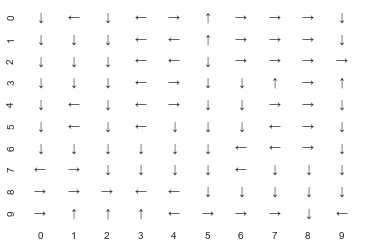

In [64]:
from matplotlib.colors import ListedColormap
ax = sns.heatmap(reward_2, annot=True)
plt.show()

ax1 = sns.heatmap(max_reward, annot=True)
plt.show()

policy_computed = val_iteration_fn(max_reward, state_space, action_set, discount)

print(policy_computed)
import sys
arrows = [u'\u2191', u'\u2190',u'\u2193',u'\u2192']
arrow_matrix = np.array(policy_computed, dtype=object)
# print arrows
for i in range(0, 10):
    for j in range(0, 10):
        index = int(policy_computed[i][j])
        arrow_matrix[i][j] = arrows[index]

sns.heatmap(policy_computed, annot=arrow_matrix, fmt='',cbar=False,cmap=ListedColormap(['white']))

count =0;
for i in range(10):
    for j in range(10):
        if(policy_computed[i][j]==actual_policy[i][j]):
            count+=1;
accuracy=count/100.0;
print(accuracy)

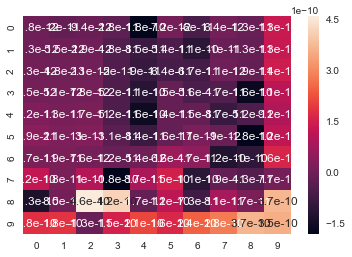

[[-1.81733161e-12 -1.99202545e-11 -9.41939763e-12 -2.78705197e-11
  -1.82441687e-10  7.22902766e-12 -6.01349426e-11  6.41648023e-12
  -1.29503179e-11  1.31760047e-10]
 [-1.25697840e-12 -5.50822693e-12 -2.91150889e-12 -4.75085484e-11
  -8.50900592e-11 -5.39043858e-11 -1.09123022e-10 -1.01251623e-11
  -1.31887807e-11  1.30519662e-10]
 [ 2.28356772e-12 -4.79055355e-13  2.06928391e-12 -4.95460904e-11
  -8.95434467e-11 -6.38847106e-11 -6.66089278e-11 -1.14006280e-12
  -1.91065552e-11  1.39661084e-10]
 [ 8.54467166e-12  5.09328118e-12  7.81262581e-12 -5.20829419e-11
  -1.14148539e-10 -1.53091041e-11 -5.62486525e-11 -4.71015886e-11
  -1.63559744e-10  1.09610720e-10]
 [ 2.22689970e-11  1.29495675e-11  1.70947537e-11 -5.23929682e-11
  -1.59626881e-10 -1.42479254e-11 -1.49309818e-11 -8.69416687e-11
  -5.20158485e-11  9.24982147e-11]
 [ 3.91552084e-11  2.13854585e-11  2.96100742e-11 -3.10617688e-11
  -8.37937289e-11 -1.55507551e-11  1.67713608e-11 -8.95893818e-12
  -1.80978162e-10  1.18703628e-10

In [55]:
ax1 = sns.heatmap(max_reward, annot=True)
plt.show()
print (max_reward)